# Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import talib as ta #TA-Lib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score
from sklearn.model_selection import GridSearchCV
import pickle
%matplotlib inline

In [2]:
#lendo o arquivo csv
df = pd.read_csv("GBPUSD_Candlestick_1_D_BID_30.08.2018-30.12.2020.csv")


In [3]:
#arrumando a coluna gmt time para ficar só com o time e retirar a hora
from datetime import datetime
for i in range(len(df)):
    df['Gmt time'][i] = datetime.strptime(df['Gmt time'][i], '%d.%m.%Y %H:%M:%S.%f').strftime('%Y-%m-%d')

   

C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [4]:
df.set_index('Gmt time', inplace = True)

In [5]:
df = df.drop_duplicates()

# calculando features e organizando os dados no dataframe

In [6]:
df['body'] = (df['Close']-df['Open'])*10000
df['pavio_sup'] = (df['High']-df['Open'])*10000
df['pavio_inf'] = (df['Close']-df['Low'])*10000


In [7]:
df.loc[df['body']>0, 'pavio_sup']=(df['High'][df['body']>0]-df['Close'][df['body']>0])*10000
df.loc[df['body']>0, 'pavio_inf']=(df['Open'][df['body']>0]-df['Low'][df['body']>0])*10000

In [8]:
df['SMA_50'] = ta.SMA(np.array(df['Close']),timeperiod=50)
df['SMA_20'] = ta.SMA(np.array(df['Close']), timeperiod=20)
df['ATR'] = ta.ATR(np.array(df['High']),np.array(df['Low']),np.array(df['Close']),timeperiod=50)
df['CCI'] = ta.CCI(np.array(df['High']),np.array(df['Low']),np.array(df['Close']),timeperiod=20)
df['SAR'] = ta.SAR(np.array(df['High']),np.array(df['Low']))

In [9]:
for i in np.arange(1,97):
    df['return_'+str(i)]=df['Close'].pct_change(i)
    df['lag_return_'+str(i)]=df['return_1'].shift(i)

In [10]:
df.loc[:,'sobe_desce']=-1 
df.loc[df['return_1'].shift(-1)>0,'sobe_desce']=1 
df = df.drop(columns=['return_1']) 

In [11]:
df = df.dropna(axis=0, how='any')

In [12]:
df

,Open,High,Low,Close,Volume,body,pavio_sup,pavio_inf,SMA_50,SMA_20,...,lag_return_92,return_93,lag_return_93,return_94,lag_return_94,return_95,lag_return_95,return_96,lag_return_96,sobe_desce
Gmt time,,,,,,,,,,,,,,,,,,,,,
2018-12-21,1.26247,1.26247,1.26247,1.26247,0.0000,0.0,0.0,0.0,1.279074,1.265844,...,0.001736,-0.021622,0.003867,-0.017839,-0.001057,-0.018877,-0.006578,-0.025330,0.000000,1
2018-12-23,1.26452,1.27382,1.26344,1.27005,227056.1703,55.3,37.7,10.8,1.278823,1.265592,...,-0.000959,-0.017453,0.001736,-0.015747,0.003867,-0.011942,-0.001057,-0.012986,-0.006578,-1
2018-12-24,1.26947,1.27077,1.26465,1.26544,4235.3800,-40.3,13.0,7.9,1.278479,1.265109,...,0.000000,-0.020079,-0.000959,-0.021019,0.001736,-0.019320,0.003867,-0.015528,-0.001057,-1
2018-12-25,1.26749,1.27186,1.26304,1.26317,133074.9700,-43.2,43.7,1.3,1.278159,1.264652,...,0.008642,-0.021837,0.000000,-0.021837,-0.000959,-0.022776,0.001736,-0.021079,0.003867,1
2018-12-26,1.26314,1.26745,1.26157,1.26416,330736.5302,10.2,32.9,15.7,1.278029,1.264285,...,0.000353,-0.029458,0.008642,-0.021071,0.000000,-0.021071,-0.000959,-0.022010,0.001736,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,1.35452,1.35753,1.34290,1.34489,137738.9705,-96.3,30.1,19.9,1.330831,1.343004,...,-0.015237,0.034403,0.001656,0.036117,-0.013490,0.022139,-0.009083,0.012856,0.000000,1
2020-12-28,1.34489,1.35224,1.34408,1.34988,172445.6644,49.9,23.6,8.1,1.331934,1.343333,...,-0.000726,0.054305,-0.015237,0.038241,0.001656,0.039961,-0.013490,0.025932,-0.009083,1
2020-12-29,1.34989,1.36253,1.34926,1.36230,183377.2920,124.1,2.3,6.3,1.333286,1.344553,...,0.000000,0.064779,-0.000726,0.064006,-0.015237,0.047794,0.001656,0.049530,-0.013490,1


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 635 entries, 2018-12-21 to 2020-12-31
Columns: 205 entries, Open to sobe_desce
dtypes: float64(204), int64(1)
memory usage: 1022.0+ KB


In [14]:
df =df.iloc[8:]

In [15]:
df.head(100)

,Open,High,Low,Close,Volume,body,pavio_sup,pavio_inf,SMA_50,SMA_20,...,lag_return_92,return_93,lag_return_93,return_94,lag_return_94,return_95,lag_return_95,return_96,lag_return_96,sobe_desce
Gmt time,,,,,,,,,,,,,,,,,,,,,
2018-12-31,1.27526,1.27526,1.27526,1.27526,0.0000,0.0,0.0,0.0,1.276439,1.263890,...,0.000000,-0.024016,-0.003022,-0.026965,0.004707,-0.022385,0.001128,-0.021282,0.000353,-1
2019-01-01,1.27459,1.27729,1.25808,1.26060,237090.4674,-139.9,27.0,25.2,1.275572,1.264123,...,0.006888,-0.035235,0.000000,-0.035235,-0.003022,-0.038150,0.004707,-0.033623,0.001128,1
2019-01-02,1.26060,1.26472,1.24250,1.26278,268812.2580,21.8,19.4,181.0,1.274637,1.264843,...,-0.000676,-0.040178,0.006888,-0.033567,0.000000,-0.033567,-0.003022,-0.036487,0.004707,1
2019-01-03,1.26268,1.27443,1.26157,1.27170,259746.4183,90.2,27.3,11.1,1.273827,1.265284,...,-0.000365,-0.032744,-0.000676,-0.033398,0.006888,-0.026740,0.000000,-0.026740,-0.003022,-1
2019-01-04,1.27170,1.27170,1.27170,1.27170,0.0000,0.0,0.0,0.0,1.273140,1.265615,...,0.008841,-0.032391,-0.000365,-0.032744,-0.000676,-0.033398,0.006888,-0.026740,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-21,1.29892,1.29976,1.29750,1.29772,67028.1503,-12.0,8.4,2.2,1.312532,1.305101,...,0.007064,0.027669,0.001729,0.029446,-0.011496,0.017612,0.000000,0.017612,0.004593,-1
2019-04-22,1.29772,1.30188,1.29277,1.29345,147423.5909,-42.7,41.6,6.8,1.312303,1.304626,...,0.000000,0.017103,0.007064,0.024288,0.001729,0.026059,-0.011496,0.014264,0.000000,-1
2019-04-23,1.29342,1.29635,1.28875,1.28993,158211.4995,-34.9,29.3,11.8,1.311910,1.303617,...,0.004561,0.014335,0.000000,0.014335,0.007064,0.021500,0.001729,0.023267,-0.011496,-1


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 627 entries, 2018-12-31 to 2020-12-31
Columns: 205 entries, Open to sobe_desce
dtypes: float64(204), int64(1)
memory usage: 1009.1+ KB


# definindo o tamanho total da amostra para trabalhar


In [17]:
#tamanho da amostra
amostra = df.iloc[:600]

In [18]:
amostra.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 2018-12-31 to 2020-11-30
Columns: 205 entries, Open to sobe_desce
dtypes: float64(204), int64(1)
memory usage: 965.6+ KB


In [19]:
amostra.head()

,Open,High,Low,Close,Volume,body,pavio_sup,pavio_inf,SMA_50,SMA_20,...,lag_return_92,return_93,lag_return_93,return_94,lag_return_94,return_95,lag_return_95,return_96,lag_return_96,sobe_desce
Gmt time,,,,,,,,,,,,,,,,,,,,,
2018-12-31,1.27526,1.27526,1.27526,1.27526,0.0000,0.0,0.0,0.0,1.276439,1.263890,...,0.000000,-0.024016,-0.003022,-0.026965,0.004707,-0.022385,0.001128,-0.021282,0.000353,-1
2019-01-01,1.27459,1.27729,1.25808,1.26060,237090.4674,-139.9,27.0,25.2,1.275572,1.264123,...,0.006888,-0.035235,0.000000,-0.035235,-0.003022,-0.038150,0.004707,-0.033623,0.001128,1
2019-01-02,1.26060,1.26472,1.24250,1.26278,268812.2580,21.8,19.4,181.0,1.274637,1.264843,...,-0.000676,-0.040178,0.006888,-0.033567,0.000000,-0.033567,-0.003022,-0.036487,0.004707,1
2019-01-03,1.26268,1.27443,1.26157,1.27170,259746.4183,90.2,27.3,11.1,1.273827,1.265284,...,-0.000365,-0.032744,-0.000676,-0.033398,0.006888,-0.026740,0.000000,-0.026740,-0.003022,-1
2019-01-04,1.27170,1.27170,1.27170,1.27170,0.0000,0.0,0.0,0.0,1.273140,1.265615,...,0.008841,-0.032391,-0.000365,-0.032744,-0.000676,-0.033398,0.006888,-0.026740,0.000000,1


# definindo o tamanho da janela


In [72]:
window = 240
total=amostra.iloc[(window):] #restante do dataframe que ele vai ir andando pelo walk forward
len(total)

360

# Benchmark SMA

In [73]:
#logica SMA: 1 = dias comprados ; -1 = dias vendidos
amostrasma=amostra
amostrasma['price yesterday'] = amostrasma['Close'].shift(1)
amostrasma['change'] = (amostrasma['Close']/amostrasma['price yesterday'])
amostrasma['invested_SMA'] = [1 if amostrasma.loc[i,'SMA_20'] > amostrasma.loc[i,'SMA_50'] else -1 for i in amostrasma.index]
SMA=amostrasma[amostrasma['invested_SMA']==1]
amostrasma['retorno']=np.cumprod(SMA['change'])

janela = 240
total=amostrasma.iloc[(janela):] #restante do dataframe que ele vai ir andando pelo walk forward

#listas para receberem valores
pontosSma=[]
diasSma=[]
close=[]
sinal=[]
SMA50=[]
SMA20=[]
yprice=[]
change=[]
invistedSMA=[]
retorno=[]

for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    outSample = amostrasma.iloc[t:(janela)]
    inSample = amostrasma.iloc[(janela):(janela+60)] #trocar o indice
    
      
    #coleta os valores nas janelas de operação
    pontosSma.extend(inSample['body'])
    diasSma.extend(inSample.index)
    close.extend(inSample['Close'])
    
    SMA50.extend(inSample['SMA_50'])
    SMA20.extend(inSample['SMA_20'])
    yprice.extend(inSample['price yesterday'])
    change.extend(inSample['change'])
    invistedSMA.extend(inSample['invested_SMA'])
    retorno.extend(inSample['retorno'])
    
    #desliza a janela em 60 que é o número do conjunto de teste
  
    janela= janela+60
    print(janela)

300
360
420
480
540
600


C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [74]:
#criação de dataframe para calculo de retornos e metricas
dfSMA = pd.DataFrame(diasSma)
dfSMA.columns=['Data']
dfSMA.set_index('Data', inplace = True)
dfSMA.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
dfSMA.insert(loc=1, column='Close', value=close, allow_duplicates=False)
dfSMA.insert(loc=2, column='SMA_50', value=SMA50, allow_duplicates=False)
dfSMA.insert(loc=3, column='SMA_20', value=SMA20, allow_duplicates=False)
dfSMA.insert(loc=4, column='yesterday price', value=yprice, allow_duplicates=False)
dfSMA.insert(loc=5, column='change', value=change, allow_duplicates=False)
dfSMA.insert(loc=6, column='retorno', value=retorno, allow_duplicates=False)
dfSMA.insert(loc=7, column='invisted sma', value=invistedSMA, allow_duplicates=False)

In [75]:
saldo=1000
for i in np.arange(1,len(diasSma)):
    if invistedSMA[i]==1:
        saldo=saldo +(dfSMA['Close'].iloc[i]-dfSMA['yesterday price'].iloc[i])*1000
        dfSMA['Saldo'].iloc[i]=saldo
    else:
        saldo=saldo + (dfSMA['yesterday price'].iloc[i]-dfSMA['Close'].iloc[i])*1000
        dfSMA['Saldo'].iloc[i]=saldo

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [68]:
(dfSMA['Close'].iloc[2]-dfSMA['yesterday price'].iloc[2])*1000

22.73999999999998

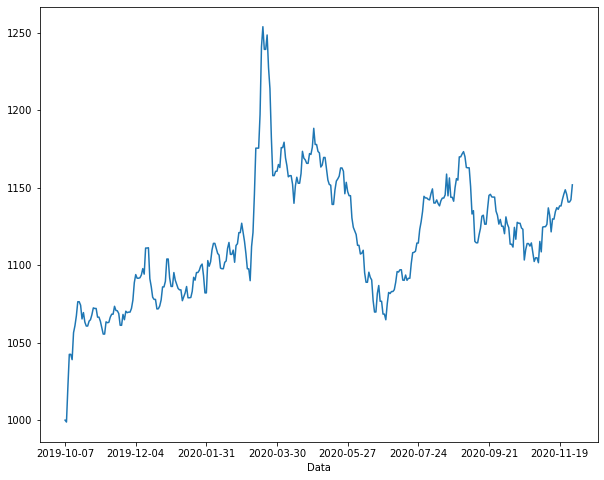

In [76]:
dfSMA['Saldo'].plot(figsize=(10,8))

In [77]:
dfSMA

,Saldo,Close,SMA_50,SMA_20,yesterday price,change,retorno,invisted sma
Data,,,,,,,,
2019-10-07,1000.00,1.22162,1.227973,1.236926,1.22881,0.994149,1.010395,1
2019-10-08,998.78,1.22040,1.228232,1.235827,1.22162,0.999001,1.009386,1
2019-10-09,1021.52,1.24314,1.228978,1.235501,1.22040,1.018633,1.028194,1
2019-10-10,1042.46,1.26408,1.230156,1.236367,1.24314,1.016844,1.045513,1
2019-10-11,1042.46,1.26408,1.231287,1.236967,1.26408,1.000000,1.045513,1
...,...,...,...,...,...,...,...,...
2020-11-25,1145.70,1.33566,1.306775,1.322022,1.33860,0.997804,1.117892,1
2020-11-26,1140.72,1.33068,1.307675,1.323292,1.33566,0.996272,1.113724,1
2020-11-27,1140.72,1.33068,1.308461,1.324899,1.33068,1.000000,1.113724,1


# Métricas SMA


In [78]:
dfSMA['Retorno']=dfSMA['Saldo'].pct_change()
dfSMA['R. Acumulado'] = (1+dfSMA['Retorno']).cumprod()
dfSMA['Retorno'].iloc[0] = 0
dfSMA['R. Acumulado'].iloc[0]=0

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [79]:
#primeiro calcular o indice sharpe pegando a media do retorno diario e dividindo pelo desvio padrão
Sharpe_SMA = (dfSMA['Retorno'].mean()*(255-0.01))/(dfSMA['Retorno'].std()*np.sqrt(255))
print(Sharpe_SMA)

0.9749300472022574


In [80]:
#Retorno anualizado
Retorno_anualizadoSMA= (1+dfSMA['Retorno'].sum())**0.5
print(Retorno_anualizadoSMA)

1.0722320104524112


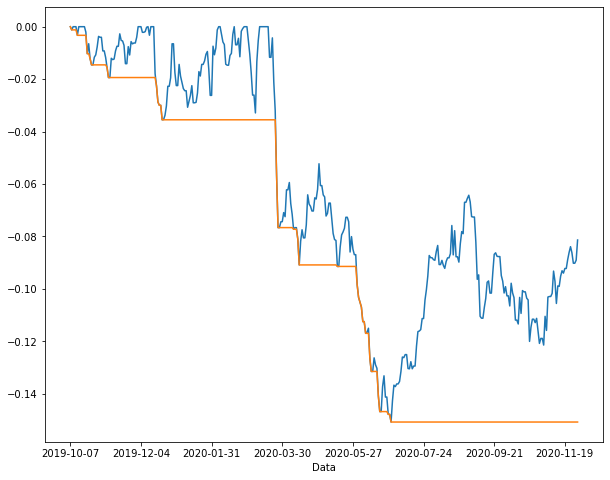

In [81]:
#MDD
Roll_Max2 = dfSMA['Saldo'].cummax()
Daily_Drawdown2 = dfSMA['Saldo']/Roll_Max2 - 1.0
MDDSMA = Daily_Drawdown2.cummin()
# Plotando o resultado
Daily_Drawdown2.plot(figsize =(10,8))
MDDSMA.plot(figsize=(10,8))

In [82]:
MDDSMA.min()

-0.15082105800441747

In [83]:
#Calmar
Calmar_SMA = (-dfSMA['Retorno'].mean()*255)/MDDSMA.min()
print(Calmar_SMA)

0.7029813082604072


# Benchmark ATR

In [84]:
amostraATR= amostra

janela = 240
total=amostraATR.iloc[(janela):] #restante do dataframe que ele vai ir andando pelo walk forward

#listas para receberem valores
pontosAtr=[]
diasAtr=[]
close=[]
sinal=[]
ATR=[]
yprice=[]
change=[]
retorno=[]

for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    outSample = amostraATR.iloc[t:(janela)]
    inSample = amostraATR.iloc[(janela):(janela+60)] #trocar o indice
    
      
    #coleta os valores nas janelas de operação
    pontosSma.extend(inSample['body'])
    diasAtr.extend(inSample.index)
    close.extend(inSample['Close'])
    ATR.extend(inSample['ATR'])
    
    
    #desliza a janela em 60 que é o número do conjunto de teste
  
    janela= janela+60
    print(janela)

300
360
420
480
540
600


In [85]:
dfATR = pd.DataFrame(diasAtr)
dfATR.columns=['Data']
dfATR.set_index('Data', inplace = True)
dfATR.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
dfATR.insert(loc=1, column='Close', value=close, allow_duplicates=False)
dfATR.insert(loc=2, column='ATR', value=ATR, allow_duplicates=False)
dfATR.insert(loc=3, column ='flag',value = 0, allow_duplicates=False)
saldo=1000

In [86]:
#logica atr
saldo=1000
flag = 0
for i in np.arange(1,len(diasAtr)):
    
    if ATR[i]>0.008:
        flag = -1
        dfATR['flag'].iloc[i]= flag
    elif ATR[i] < 0.0065:
        flag = 1
        dfATR['flag'].iloc[i]= flag

    if flag ==1:
        saldo=saldo + (dfATR['Close'].iloc[i]-dfATR['Close'].iloc[i-1])*1000
        dfATR['Saldo'].iloc[i]=saldo
    elif flag == -1:
        saldo=saldo + (dfATR['Close'].iloc[i-1]-dfATR['Close'].iloc[i])*1000
        dfATR['Saldo'].iloc[i]=saldo
    elif flag==0:
        saldo=saldo

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


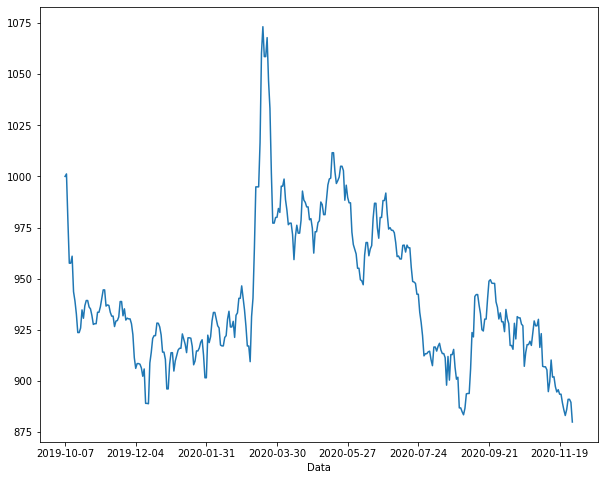

In [87]:
dfATR['Saldo'].plot(figsize=(10,8))

In [88]:
dfATR

,Saldo,Close,ATR,flag
Data,,,,
2019-10-07,1000.00,1.22162,0.008067,0
2019-10-08,1001.22,1.22040,0.008093,-1
2019-10-09,978.48,1.24314,0.008463,-1
2019-10-10,957.54,1.26408,0.008894,-1
2019-10-11,957.54,1.26408,0.008716,-1
...,...,...,...,...
2020-11-25,885.96,1.33566,0.010008,-1
2020-11-26,890.94,1.33068,0.009995,-1
2020-11-27,890.94,1.33068,0.009795,-1


# Métricas ATR

In [89]:
dfATR['Retorno']=dfATR['Saldo'].pct_change()
dfATR['R. Acumulado'] = (1+dfATR['Retorno']).cumprod()
dfATR['Retorno'].iloc[0] = 0
dfATR['R. Acumulado'].iloc[0]=0

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [90]:
# Sharpe

Sharpe_ATR= (dfATR['Retorno'].mean()*(255-0.01))/(dfATR['Retorno'].std()*np.sqrt(255))
print(Sharpe_ATR)

-0.6405062382241615


In [91]:
# Retorno anualizado
Retorno_anualizadoATR= (1+dfATR['Retorno'].sum())**0.5
print(Retorno_anualizadoATR)

0.9400137397499336


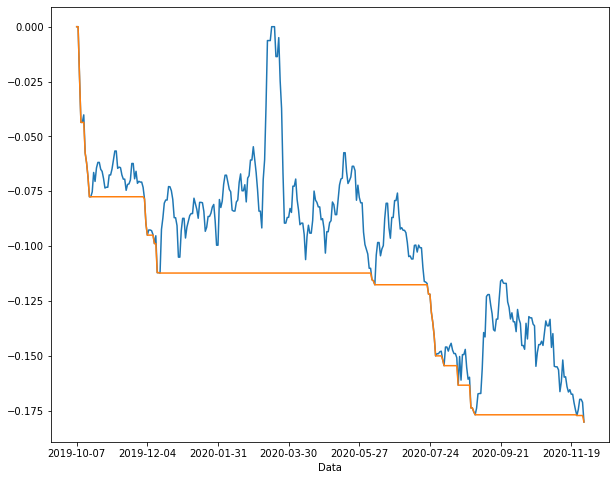

In [92]:
#MDD
Roll_Max2 = dfATR['Saldo'].cummax()
Daily_Drawdown2 = dfATR['Saldo']/Roll_Max2 - 1.0
MDDATR = Daily_Drawdown2.cummin()
# Plotando o resultado
Daily_Drawdown2.plot(figsize =(10,8))
MDDATR.plot(figsize=(10,8))

In [93]:
MDDATR.min()

-0.1802189610994639

In [94]:
#Calmar
Calmar_ATR = (-dfATR['Retorno'].mean()*255)/MDDATR.min()
print(Calmar_ATR)

-0.45739750465985035


# Benchmark SAR

In [95]:
amostrasar = amostra

janela = 240
total=amostrasar.iloc[(janela):] #restante do dataframe que ele vai ir andando pelo walk forward

#listas para receberem valores
pontosSar=[]
diasSar=[]
close=[]
sinal=[]
SAR=[]
yprice=[]
change=[]
retorno=[]

for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    outSample = amostrasar.iloc[t:(janela)]
    inSample = amostrasar.iloc[(janela):(janela+60)] #trocar o indice
    
      
    #coleta os valores nas janelas de operação
    pontosSar.extend(inSample['body'])
    diasSar.extend(inSample.index)
    close.extend(inSample['Close'])
    SAR.extend(inSample['SAR'])
    
    
    #desliza a janela em 60 que é o número do conjunto de teste
  
    janela= janela+60
    print(janela)

300
360
420
480
540
600


In [96]:
dfSAR = pd.DataFrame(diasSar)
dfSAR.columns=['Data']
dfSAR.set_index('Data', inplace = True)
dfSAR.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
dfSAR.insert(loc=1, column='Close', value=close, allow_duplicates=False)
dfSAR.insert(loc=2, column='SAR', value=SAR, allow_duplicates=False)


In [97]:
saldo=1000
for i in np.arange(1,len(diasSma)):
    if SAR[i]< close[i]:
        saldo=saldo +(dfSAR['Close'].iloc[i]-dfSAR['Close'].iloc[i-1])*1000
        dfSAR['Saldo'].iloc[i]=saldo
    else:
        saldo=saldo + (dfSAR['Close'].iloc[i-1]-dfSAR['Close'].iloc[i])*1000
        dfSAR['Saldo'].iloc[i]=saldo

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


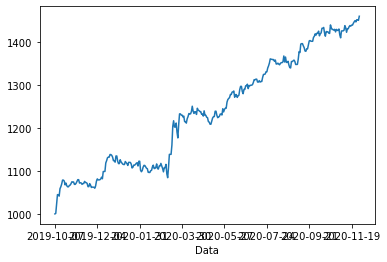

In [98]:
dfSAR['Saldo'].plot(fig=(10,8))

In [99]:
dfSAR

,Saldo,Close,SAR
Data,,,
2019-10-07,1000.00,1.22162,1.239350
2019-10-08,1001.22,1.22040,1.237364
2019-10-09,1023.96,1.24314,1.219490
2019-10-10,1044.90,1.26408,1.219750
2019-10-11,1044.90,1.26408,1.220290
...,...,...,...
2020-11-25,1447.64,1.33566,1.327392
2020-11-26,1452.62,1.33068,1.339750
2020-11-27,1452.62,1.33068,1.339750


# Métricas SAR

In [100]:
dfSAR['Retorno']=dfSAR['Saldo'].pct_change()
dfSAR['R. Acumulado'] = (1+dfSAR['Retorno']).cumprod()


In [101]:
# Sharpe

Sharpe_SAR= (dfSAR['Retorno'].mean()*(255-0.01))/(dfSAR['Retorno'].std()*np.sqrt(255))
print(Sharpe_SAR)

2.692609133907006


In [102]:
# Retorno anualizado
Retorno_anualizadoSAR= (1+dfSAR['Retorno'].sum())**0.5
print(Retorno_anualizadoSAR)

1.177473676540271


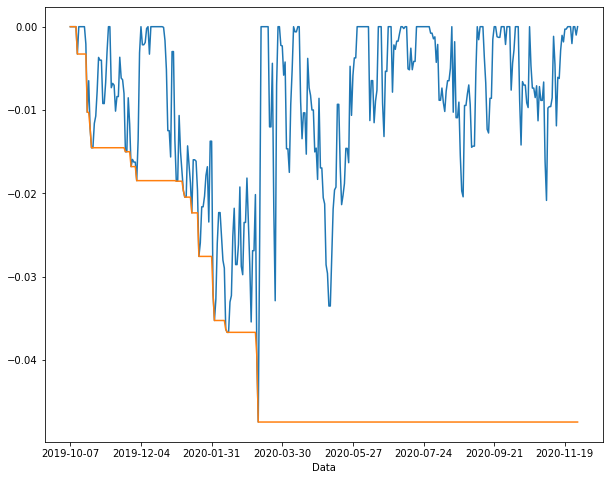

In [103]:
#MDD
Roll_Max2 = dfSAR['Saldo'].cummax()
Daily_Drawdown2 = dfSAR['Saldo']/Roll_Max2 - 1.0
MDDSAR = Daily_Drawdown2.cummin()
# Plotando o resultado
Daily_Drawdown2.plot(figsize =(10,8))
MDDSAR.plot(figsize=(10,8))

In [104]:
MDDSAR.min()

-0.04746804866265508

In [105]:
#Calmar
Calmar_SAR = (-dfSAR['Retorno'].mean()*255)/MDDSAR.min()
print(Calmar_SAR)

5.782707330278428


# Benchmark CCI

In [106]:
amostraCCI=amostra

janela = 240
total=amostraCCI.iloc[(janela):] #restante do dataframe que ele vai ir andando pelo walk forward

#listas para receberem valores
pontosCci=[]
diasCci=[]
close=[]
sinal=[]
CCI=[]
yprice=[]
change=[]
retorno=[]

for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    outSample = amostraCCI.iloc[t:(janela)]
    inSample = amostraCCI.iloc[(janela):(janela+60)] #trocar o indice
    
      
    #coleta os valores nas janelas de operação
    pontosCci.extend(inSample['body'])
    diasCci.extend(inSample.index)
    close.extend(inSample['Close'])
    CCI.extend(inSample['CCI'])
    
    
    #desliza a janela em 60 que é o número do conjunto de teste
  
    janela= janela+60
    print(janela)

300
360
420
480
540
600


In [107]:
dfCCI = pd.DataFrame(diasCci)
dfCCI.columns=['Data']
dfCCI.set_index('Data', inplace = True)
dfCCI.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
dfCCI.insert(loc=1, column='Close', value=close, allow_duplicates=False)
dfCCI.insert(loc=2, column='CCI', value=CCI, allow_duplicates=False)
dfCCI.insert(loc=3, column='flag',value=0,allow_duplicates=False)

In [108]:
saldo=1000
flag = 0
for i in np.arange(1,len(diasCci)):
    
    if CCI[i]>100:
        flag = 1
        dfCCI['flag'].iloc[i]= flag
    elif CCI[i] < -100:
        flag = -1
        dfCCI['flag'].iloc[i]= flag

    if flag ==1:
        saldo=saldo + (dfCCI['Close'].iloc[i]-dfCCI['Close'].iloc[i-1])*1000
        dfCCI['Saldo'].iloc[i]=saldo
    elif flag == -1:
        saldo=saldo + (dfCCI['Close'].iloc[i-1]-dfCCI['Close'].iloc[i])*1000
        dfCCI['Saldo'].iloc[i]=saldo
    elif flag==0:
        saldo=saldo

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


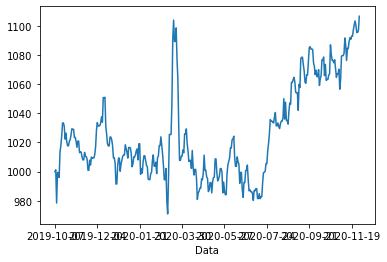

In [109]:
dfCCI['Saldo'].plot(fig=(10,8))

# Métricas CCI

In [110]:
dfCCI['Retorno']=dfCCI['Saldo'].pct_change()
dfCCI['R. Acumulado'] = (1+dfCCI['Retorno']).cumprod()
dfCCI['Retorno'].iloc[0] = 0
dfCCI['R. Acumulado'].iloc[0]=0

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [111]:
# Sharpe

Sharpe_CCI= (dfCCI['Retorno'].mean()*(255-0.01))/(dfCCI['Retorno'].std()*np.sqrt(255))
print(Sharpe_CCI)

0.6579592069923914


In [112]:
# Retorno anualizado
Retorno_anualizadoCCI= (1+dfCCI['Retorno'].sum())**0.5
print(Retorno_anualizadoCCI)

1.0541676630240457


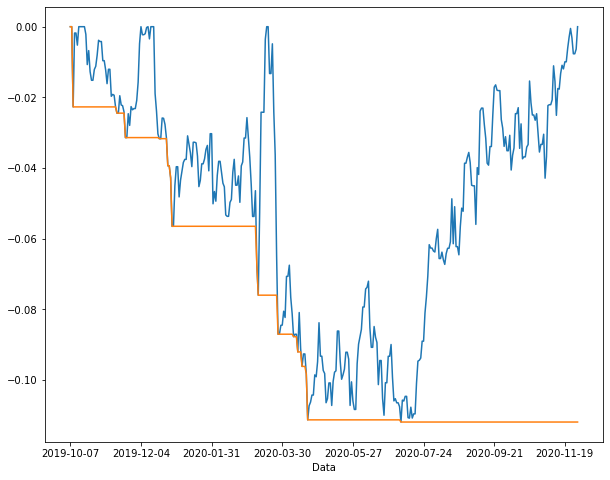

In [113]:
#MDD
Roll_Max2 = dfCCI['Saldo'].cummax()
Daily_Drawdown2 = dfCCI['Saldo']/Roll_Max2 - 1.0
MDDCCI = Daily_Drawdown2.cummin()
# Plotando o resultado
Daily_Drawdown2.plot(figsize =(10,8))
MDDCCI.plot(figsize=(10,8))

In [114]:
MDDCCI.min()

-0.11193752661188772

In [115]:
#Calmar
Calmar_CCI= (-dfCCI['Retorno'].mean()*255)/MDDCCI.min()
print(Calmar_CCI)

0.7041058627629857


#  faz-se o tuning utilizando o grid_search para rodar o random forest sem a tunagem a cada passo


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
# Criando a matriz de parametros
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 60, 70, 80, 90 , 100, 110],
    'max_features': [2 ,3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [5, 6, 7, 8, 9, 10, 11],
    'n_estimators': [ 200, 300, 400, 500, 600],
    'random_state':[0,42]
}
# instanciando o modelo de machine learning
rf = RandomForestClassifier()
# instanciando o grid search
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [23]:
for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    treino = amostra.iloc[t:(window)]
    Y_treino=treino['sobe_desce']
    X_treino = treino.drop(columns = ['sobe_desce'])
    a_teste = amostra.iloc[(window):(window+60)] #troca o indice
    Y_teste = a_teste['sobe_desce']
    X_teste = a_teste.drop(columns = ['sobe_desce'])
    

    grid_search.fit(X_treino, Y_treino)
    yrf_pred=grid_search.predict(X_teste)
    acuracia=accuracy_score(Y_teste, yrf_pred)

    
    
    window= window+60
    print(grid_search.best_params_)
    print(acuracia)

Fitting 3 folds for each of 2940 candidates, totalling 8820 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 27.5min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 32.7min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 38.4min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 44.5min
[Parallel(n_jobs=-1)]: Done 8820 out of 8820 |

{'bootstrap': True, 'max_depth': 50, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200, 'random_state': 42}
0.5166666666666667
Fitting 3 folds for each of 2940 candidates, totalling 8820 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 29.1min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 34.5min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 40.5min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 46.8min
[Parallel(n_jobs=-1)]: Done 8820 out of 8820 |

{'bootstrap': True, 'max_depth': 50, 'max_features': 2, 'min_samples_leaf': 4, 'min_samples_split': 11, 'n_estimators': 200, 'random_state': 42}
0.6166666666666667
Fitting 3 folds for each of 2940 candidates, totalling 8820 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  8.3min


KeyboardInterrupt: 

# agora pegando os parametros que apresentaram uma maior acurácia no grid_search , faz-se o walkforward com eles

In [30]:
window = 240
total=amostra.iloc[(window):] #restante do dataframe que ele vai ir andando pelo walk forward
len(total)

360

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
rf = RandomForestClassifier(random_state= 0,bootstrap = True, max_depth = 50, max_features= 3, min_samples_leaf = 3, min_samples_split= 10, n_estimators = 200)


In [32]:
#lista para armazenar os valores preditos
predicoes=[]
#lista para armazenar os valores reais
valor_real=[]
#lista de pips
pontos = []
#lista para as datas para o index
dias=[]


In [33]:
for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    treino = amostra.iloc[t:(window)]
    Y_treino=treino['sobe_desce']
    X_treino = treino.drop(columns = ['sobe_desce'])
    a_teste = amostra.iloc[(window):(window+60)] #trocar o indice
    Y_teste = a_teste['sobe_desce']
    X_teste = a_teste.drop(columns = ['sobe_desce'])
    
    
    #faz a predição e coleta o valor
    rf.fit(X_treino,Y_treino)
    yrf_pred=rf.predict(X_teste)
    acuracia=accuracy_score(Y_teste, yrf_pred)
    pontos.extend(X_teste['body'])
    predicoes.extend(yrf_pred)
    dias.extend(X_teste.index)
   
    
  
    #coleta os valores reais da saída
    valor_real.extend(Y_teste)
    
    #desliza a janela em 60 que é o número do conjunto de teste
  
    window= window+60
    
    print(acuracia)
# 0.5333333333333333
# 0.5833333333333334
# 0.6166666666666667
# 0.5
# 0.6
# 0.55

0.5166666666666667
0.6
0.6166666666666667
0.5666666666666667
0.6166666666666667
0.4666666666666667


# implementando a estratégia:

# defini de uma forma bem simples que o ganho/perda do dia seria a diferença de abertura - fechamento da vela
# se o valor predito fosse igual ao valor real da ordem ( 1 -> compra ; -1 -> venda), ele somaria os pips ao saldo caso estivesse correto ou subtrairia caso estivesse errado.



In [34]:
saldo = 1000


In [35]:
lucro = pd.DataFrame(dias)

In [36]:
lucro.columns=['Data']

In [37]:
lucro.set_index('Data', inplace = True)

In [38]:
lucro.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)

In [39]:
lucro.head()

,Saldo
Data,
2019-10-07,1000
2019-10-08,1000
2019-10-09,1000
2019-10-10,1000
2019-10-11,1000


In [40]:
saldo

1000

In [41]:
for i in np.arange(1,len(predicoes)):
    
    if predicoes[i] == valor_real[i]:
        saldo = saldo + abs(pontos[i]*0.1)
        lucro.iloc[i] = saldo
         
    else:
        saldo = saldo - abs(pontos[i]*0.1)
        lucro.iloc[i] = saldo     
       
    
#     print(saldo)

In [42]:
lucro

,Saldo
Data,
2019-10-07,1000.00
2019-10-08,998.76
2019-10-09,976.02
2019-10-10,997.37
2019-10-11,997.37
...,...
2020-11-25,1419.75
2020-11-26,1424.67
2020-11-27,1424.67


In [43]:
lucro['Retorno']=lucro['Saldo'].pct_change()

In [44]:
lucro['R. Acumulado'] = (1+lucro['Retorno']).cumprod()

In [45]:
lucro['Retorno'].iloc[0] = 0
lucro['R. Acumulado'].iloc[0]=0

In [46]:
lucro.head()

,Saldo,Retorno,R. Acumulado
Data,,,
2019-10-07,1000.00,0.000000,0.00000
2019-10-08,998.76,-0.001240,0.99876
2019-10-09,976.02,-0.022768,0.97602
2019-10-10,997.37,0.021875,0.99737
2019-10-11,997.37,0.000000,0.99737


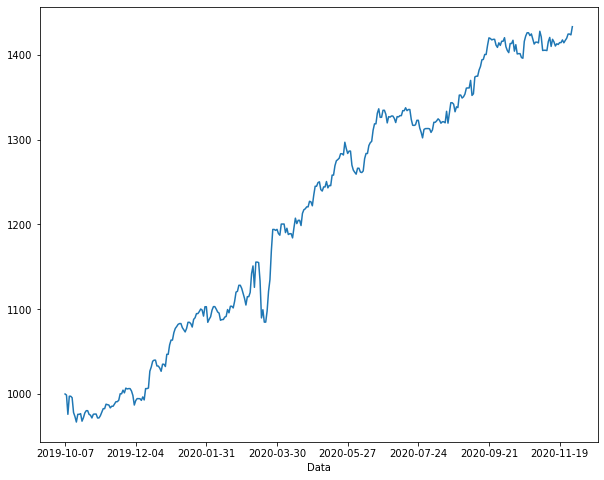

In [47]:
lucro['Saldo'].plot(figsize=(10,8))

In [57]:
lucro.insert(loc=0, column='Ordem', value=predicoes, allow_duplicates=False)

C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Unrecognized location 'upper Left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  if __name__ == '__main__':


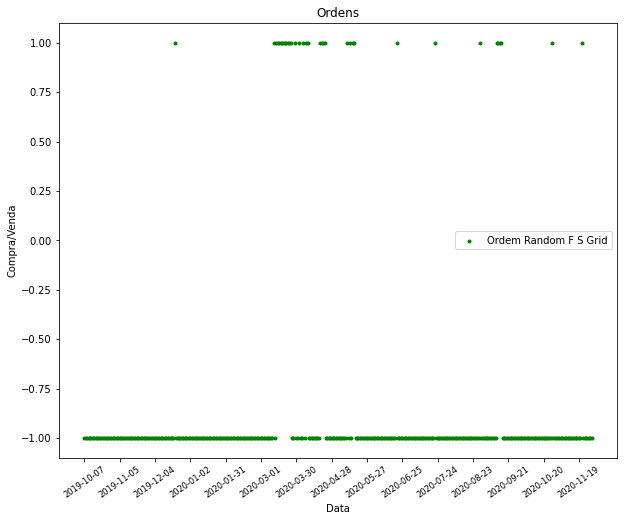

In [57]:
#Visualizando graficamente os sinais de compra e venda
plt.figure(figsize= (10,8))
plt.scatter(lucro.index, lucro['Ordem'], color = 'green', label = 'Ordem Random F S Grid', marker = '.', alpha=1)
# plt.plot(lucro['Saldo'], label='Retorno', alpha =0.35)
plt.title('Ordens')
plt.xticks(lucro.index[::25], size ='small', rotation=35 )
plt.xlabel('Data')
plt.ylabel('Compra/Venda')
plt.legend( loc = 'upper Left')
plt.show()

# Métricas de desempenho


# Índice de Sharpe


In [58]:
#primeiro calcular o indice sharpe pegando a media do retorno diario e dividindo pelo desvio padrão
Sharpe_Ratio1 = (lucro['Retorno'].mean()*(255-0.01) )/(lucro['Retorno'].std()*np.sqrt(255)) # mean = return_series.mean() * N -rf
print(Sharpe_Ratio1)

2.4961835941570794


# Retorno anualizado

In [59]:
Retorno_anualizado1 = (1+lucro['Retorno'].sum())**0.5

In [60]:
print(Retorno_anualizado1)

1.16956080530772


# Máximo Drawdown

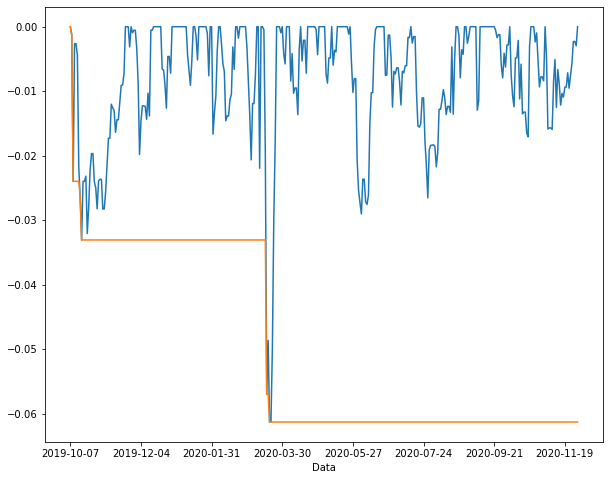

In [61]:
Roll_Max1 = lucro['Saldo'].cummax()
Daily_Drawdown1 = lucro['Saldo']/Roll_Max1 - 1.0
MDD1 = Daily_Drawdown1.cummin()
# Plotando o resultado
Daily_Drawdown1.plot(figsize =(10,8))
MDD1.plot(figsize=(10,8))

In [62]:
MDD1.min()

-0.061300427476159935

# Índice de Calmar

In [63]:
Calmar_Ratio1 = (-lucro['Retorno'].mean()*255)/MDD1.min()
print(Calmar_Ratio1)

4.250807846280839


# Calculando o walkforward com o grid_search a cada passo

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
# cria matriz de parâmetros 
param_grid = {
    'bootstrap': [True],
    'max_depth': [40, 50, 60],
    'max_features': [2 ,3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [5, 6, 7, 8, 9, 10, 11],
    'n_estimators': [ 200, 300, 400, 500, 600],
    'random_state': [0, 42]
}
# instanciando o modelo de machine learning
rf = RandomForestClassifier()
# instanciando o grid search
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [22]:
window = 240
total=amostra.iloc[(window):] #restante do dataframe que ele vai ir andando pelo walk forward
len(total)

360

In [23]:
#lista para armazenar os valores preditos
predicoes=[]
#lista para armazenar os valores reais
valor_real=[]
#lista de pips
pontos = []
#lista para as datas para o index
dias=[]

for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    treino = amostra.iloc[t:(window)]
    Y_treino=treino['sobe_desce']
    X_treino = treino.drop(columns = ['sobe_desce'])
    a_teste = amostra.iloc[(window):(window+60)] #troca o indice
    Y_teste = a_teste['sobe_desce']
    X_teste = a_teste.drop(columns = ['sobe_desce'])
    
    #faz a predição e coleta o valor

    
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
    grid_search.fit(X_treino, Y_treino)
    yrf_pred=grid_search.predict(X_teste)
    acuracia=accuracy_score(Y_teste, yrf_pred)

    pontos.extend(X_teste['body'])
    predicoes.extend(yrf_pred)
    dias.extend(X_teste.index)
   
    
  
    #coleta os valores reais da saída
    valor_real.extend(Y_teste)
    
    
    window= window+60
    print(acuracia)

Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed: 21.3min finished


0.5166666666666667
Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed: 22.1min finished


0.6166666666666667
Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed: 21.6min finished


0.6666666666666666
Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed: 21.2min finished


0.5833333333333334
Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed: 21.2min finished


0.6
Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed: 20.2min finished


0.5333333333333333


# Calculando retornos com WFA com grid search a cada passo

In [24]:
saldo = 1000


In [25]:
#dataframe para calculos de retornos e metricas
lucroWFA = pd.DataFrame(dias)
lucroWFA.columns=['Data']
lucroWFA.set_index('Data', inplace = True)
lucroWFA.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
lucroWFA.head()

,Saldo
Data,
2019-10-07,1000
2019-10-08,1000
2019-10-09,1000
2019-10-10,1000
2019-10-11,1000


In [26]:
for i in np.arange(1,len(predicoes)):
    
    if predicoes[i] == valor_real[i]:
        saldo = saldo + abs(pontos[i]*0.1)
        lucroWFA.iloc[i] = saldo
         
    else:
        saldo = saldo - abs(pontos[i]*0.1)
        lucroWFA.iloc[i] = saldo  

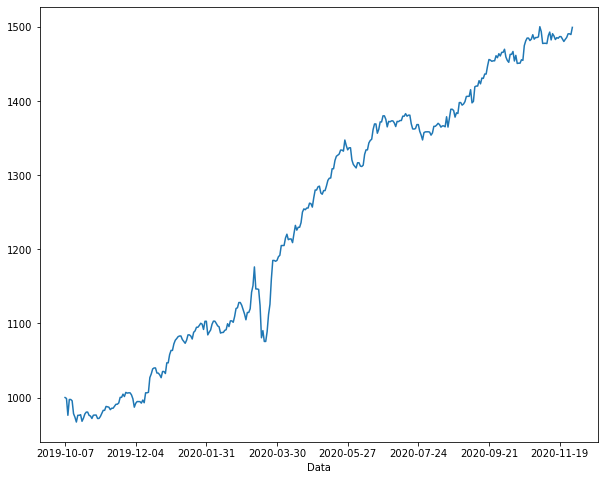

In [27]:

lucroWFA['Retorno']=lucroWFA['Saldo'].pct_change()
lucroWFA['R. Acumulado'] = (1+lucroWFA['Retorno']).cumprod()
lucroWFA['Retorno'].iloc[0] = 0
lucroWFA['R. Acumulado'].iloc[0]=0
lucroWFA['Saldo'].plot(figsize=(10,8))

In [28]:
lucroWFA.insert(loc=0, column='Ordem', value=predicoes, allow_duplicates=False)

In [29]:
lucroWFA

,Ordem,Saldo,Retorno,R. Acumulado
Data,,,,
2019-10-07,-1,1000.00,0.000000,0.00000
2019-10-08,-1,998.76,-0.001240,0.99876
2019-10-09,-1,976.02,-0.022768,0.97602
2019-10-10,-1,997.37,0.021875,0.99737
2019-10-11,-1,997.37,0.000000,0.99737
...,...,...,...,...
2020-11-25,-1,1486.11,0.001712,1.48611
2020-11-26,-1,1491.03,0.003311,1.49103
2020-11-27,-1,1491.03,0.000000,1.49103


# Métricas de desempenho


# Índice de Sharpe

In [33]:
#primeiro calcular o indice sharpe pegando a media do retorno diario e dividindo pelo desvio padrão
Sharpe_Ratio2 = (lucroWFA['Retorno'].mean()*(255-0.01))/(lucroWFA['Retorno'].std()*np.sqrt(255))
print(Sharpe_Ratio2)

2.8419622946465597


# Retorno anualizado

In [34]:
Retorno_anualizado2 = (1+lucroWFA['Retorno'].sum())**0.5
print(Retorno_anualizado2)

1.188684130891161


# Máximo Drawdown

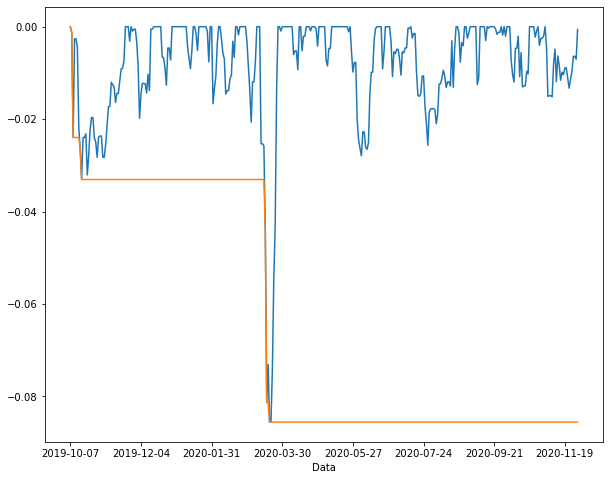

In [35]:
Roll_Max2 = lucroWFA['Saldo'].cummax()
Daily_Drawdown2 = lucroWFA['Saldo']/Roll_Max2 - 1.0
MDD2 = Daily_Drawdown2.cummin()
# Plotando o resultado
Daily_Drawdown2.plot(figsize =(10,8))
MDD2.plot(figsize=(10,8))

In [36]:
MDD2.min()

-0.08555349643810461

# Índice de Calmar

In [37]:
Calmar_Ratio2 = (-lucroWFA['Retorno'].mean()*255)/MDD2.min()
print(Calmar_Ratio2)

3.4191517899325863


In [38]:
lucroWFA

,Ordem,Saldo,Retorno,R. Acumulado
Data,,,,
2019-10-07,-1,1000.00,0.000000,0.00000
2019-10-08,-1,998.76,-0.001240,0.99876
2019-10-09,-1,976.02,-0.022768,0.97602
2019-10-10,-1,997.37,0.021875,0.99737
2019-10-11,-1,997.37,0.000000,0.99737
...,...,...,...,...
2020-11-25,-1,1486.11,0.001712,1.48611
2020-11-26,-1,1491.03,0.003311,1.49103
2020-11-27,-1,1491.03,0.000000,1.49103


# Fazendo o benchmark com o MACD

# Arrumando os dias da amostra

In [116]:
#tamanho da amostra
amostraMACD = amostra

# Calculando o MACD


In [117]:
# Calculando a EMA com período menor
ShortEMA = amostraMACD['Close'].ewm(span =12, adjust = False).mean()
# Calculando a EMA com período maior
LongEMA = amostraMACD['Close'].ewm(span = 26, adjust = False).mean()
# Calculando o sinal MACD
MACD = ShortEMA - LongEMA
# Calculando a linha do sinal
sinal = MACD.ewm(span = 9, adjust = False).mean()


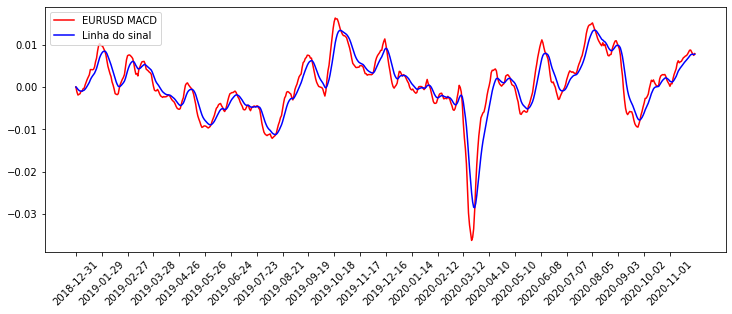

In [118]:
#plotando o gráfico
plt.figure(figsize = (12.2 , 4.5))
plt.plot(amostraMACD.index, MACD, label='EURUSD MACD', color = 'red')
plt.plot(amostraMACD.index, sinal, label = 'Linha do sinal', color = 'blue')
plt.xticks(amostraMACD.index[::25],rotation = 45)
plt.legend(loc='upper left')
plt.show()


# Adicionando a coluna com os valores do MACD no dataframe amostraMACD

In [119]:
amostraMACD['MACD'] = MACD
amostraMACD['Linha de Sinal'] = sinal
#visualizando os dados
amostraMACD.head()

C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Open,High,Low,Close,Volume,body,pavio_sup,pavio_inf,SMA_50,SMA_20,...,lag_return_95,return_96,lag_return_96,sobe_desce,price yesterday,change,invested_SMA,retorno,MACD,Linha de Sinal
Gmt time,,,,,,,,,,,,,,,,,,,,,
2018-12-31,1.27526,1.27526,1.27526,1.27526,0.0000,0.0,0.0,0.0,1.276439,1.263890,...,0.001128,-0.021282,0.000353,-1,NaN,NaN,-1,NaN,0.000000,0.000000
2019-01-01,1.27459,1.27729,1.25808,1.26060,237090.4674,-139.9,27.0,25.2,1.275572,1.264123,...,0.004707,-0.033623,0.001128,1,1.27526,0.988504,-1,NaN,-0.001169,-0.000234
2019-01-02,1.26060,1.26472,1.24250,1.26278,268812.2580,21.8,19.4,181.0,1.274637,1.264843,...,-0.003022,-0.036487,0.004707,1,1.26060,1.001729,-1,NaN,-0.001898,-0.000567
2019-01-03,1.26268,1.27443,1.26157,1.27170,259746.4183,90.2,27.3,11.1,1.273827,1.265284,...,0.000000,-0.026740,-0.003022,-1,1.26278,1.007064,-1,NaN,-0.001736,-0.000801
2019-01-04,1.27170,1.27170,1.27170,1.27170,0.0000,0.0,0.0,0.0,1.273140,1.265615,...,0.006888,-0.026740,0.000000,1,1.27170,1.000000,-1,NaN,-0.001590,-0.000959


In [120]:
#lógica MACD para trade, dias comprados (1) , dias vendidos (-1)
amostraMACD['price yesterday'] = amostraMACD['Close'].shift(1)
amostraMACD['change'] = (amostraMACD['Close']/amostraMACD['price yesterday'])

amostraMACD['invested_MACD'] = [1 if amostraMACD.loc[i,'MACD'] > amostraMACD.loc[i,'Linha de Sinal'] else -1 for i in amostraMACD.index]
MACD=amostraMACD[amostraMACD['invested_MACD']==1]
amostraMACD['retorno']=np.cumprod(MACD['change'])


C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

# Criando a função que sinalizará a compra ou venda 

In [121]:
def buy_sell(sinal):
    buy = []
    sell = []
    flag = -1
    
    for i in range(0,len(sinal)):
        if sinal['MACD'][i] > sinal['Linha de Sinal'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append(sinal['Close'][i])
                flag = 1
            else:
                buy.append(np.nan)

        elif sinal['MACD'][i] < sinal['Linha de Sinal'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append(sinal['Close'][i])
                flag = 0
            else:
                sell.append(np.nan) 
        else:
            sell.append(np.nan)
            buy.append(np.nan)
    return (buy,sell)

In [122]:
# criando as colunas buy e sell
a = buy_sell(amostraMACD)
amostraMACD['Preço para Buy'] = a[0]
amostraMACD['Preço para Sell'] = a[1]

C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


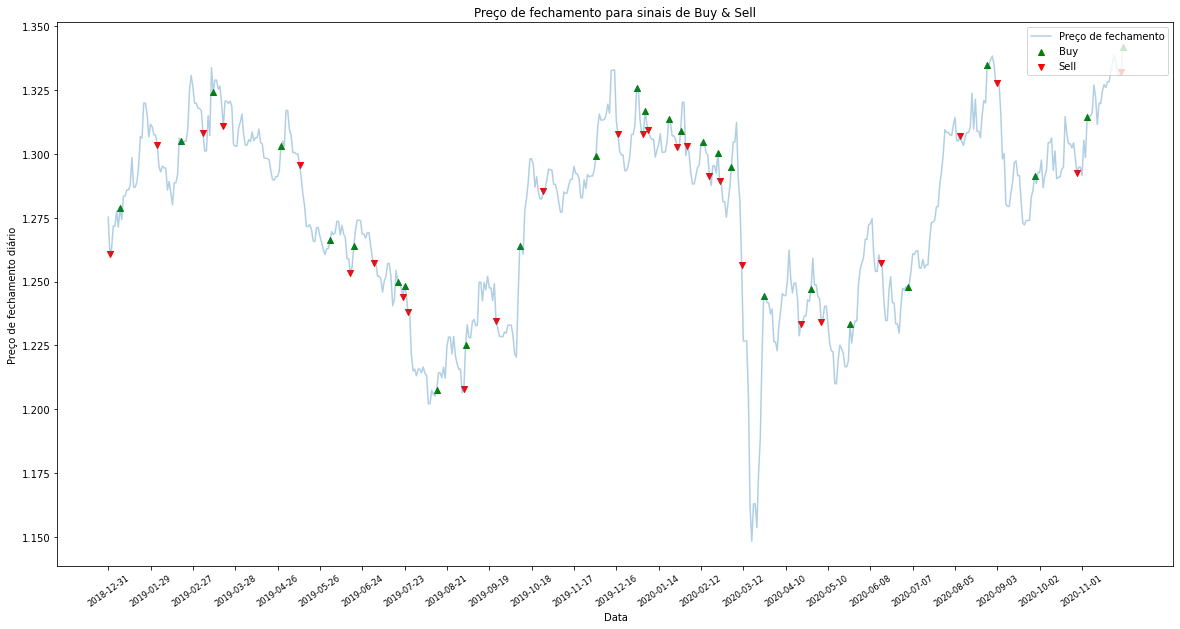

In [123]:
#Visualizando graficamente os sinais de compra e venda
plt.figure(figsize= (20,10))
plt.scatter(amostraMACD.index, amostraMACD['Preço para Buy'], color = 'green', label = 'Buy', marker = '^', alpha=1)
plt.scatter(amostraMACD.index, amostraMACD['Preço para Sell'], color = 'red', label = 'Sell', marker = 'v', alpha=1)

plt.plot(amostraMACD['Close'], label='Preço de fechamento', alpha =0.35)
plt.title('Preço de fechamento para sinais de Buy & Sell')
plt.xticks(amostraMACD.index[::25], size ='small', rotation=35 )
plt.xlabel('Data')
plt.ylabel('Preço de fechamento diário')
plt.legend( loc = 'upper right')
plt.show()

# Separando os dias de operações conforme o walkforward

In [124]:
janela = 240
total=amostraMACD.iloc[(janela):] #restante do dataframe que ele vai ir andando pelo walk forward


In [125]:
#listas para receberem valores
pontosMacd=[]
diasMacd=[]
buy =[]
sell= []
close=[]
sinal=[]
MACDl=[]
yprice=[]
change=[]
invistedMACD=[]
retorno=[]

In [126]:
for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    outSample = amostraMACD.iloc[t:(janela)]
    inSample = amostraMACD.iloc[(janela):(janela+60)] #trocar o indice
    
      
    #coleta os valores nas janelas de operação
    pontosMacd.extend(inSample['body'])
    diasMacd.extend(inSample.index)
    buy.extend(inSample['Preço para Buy'])
    sell.extend(inSample['Preço para Sell'])
    close.extend(inSample['Close'])
    sinal.extend(inSample['Linha de Sinal'])  
    MACDl.extend(inSample['MACD'])
    yprice.extend(inSample['price yesterday'])
    change.extend(inSample['change'])
    invistedMACD.extend(inSample['invested_MACD'])
    retorno.extend(inSample['retorno'])
    
    #desliza a janela em 60 que é o número do conjunto de teste
  
    janela= janela+60
    print(janela)

300
360
420
480
540
600


In [127]:
dfMACD = pd.DataFrame(diasMacd)
dfMACD.columns=['Data']
dfMACD.set_index('Data', inplace = True)
dfMACD.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
dfMACD.insert(loc=1, column='Close', value=close, allow_duplicates=False)
dfMACD.insert(loc=2, column='MACD', value=MACDl, allow_duplicates=False)
dfMACD.insert(loc=3, column='Linha de Sinal', value=sinal, allow_duplicates=False)
dfMACD.insert(loc=4, column='Buy', value=buy, allow_duplicates=False)
dfMACD.insert(loc=4, column='yesterday price', value=yprice, allow_duplicates=False)
dfMACD.insert(loc=5, column='change', value=change, allow_duplicates=False)
dfMACD.insert(loc=6, column='retorno', value=retorno, allow_duplicates=False)
dfMACD.insert(loc=7, column='invisted macd', value=invistedMACD, allow_duplicates=False)


In [128]:
saldo = 1000

In [129]:
dfMACD.head(50)

,Saldo,Close,MACD,Linha de Sinal,yesterday price,change,retorno,invisted macd,Buy
Data,,,,,,,,,
2019-10-07,1000,1.22162,-0.001379,0.000475,1.22881,0.994149,NaN,-1,NaN
2019-10-08,1000,1.22040,-0.002138,-0.000048,1.22162,0.999001,NaN,-1,NaN
2019-10-09,1000,1.24314,-0.000895,-0.000217,1.22040,1.018633,NaN,-1,NaN
2019-10-10,1000,1.26408,0.001760,0.000178,1.24314,1.016844,1.080075,1,1.26408
2019-10-11,1000,1.26408,0.003820,0.000907,1.26408,1.000000,1.080075,1,NaN
2019-10-13,1000,1.26065,0.005117,0.001749,1.26408,0.997287,1.077144,1,NaN
2019-10-14,1000,1.27805,0.007462,0.002891,1.26065,1.013802,1.092011,1,NaN
2019-10-15,1000,1.28256,0.009575,0.004228,1.27805,1.003529,1.095865,1,NaN
2019-10-16,1000,1.28893,0.011629,0.005708,1.28256,1.004967,1.101308,1,NaN


In [130]:
saldo=1000
for i in np.arange(1,len(diasMacd)):
    if invistedMACD[i]==1:
        saldo=saldo+(((dfMACD['Close'].iloc[i]-dfMACD['yesterday price'].iloc[i]))*1000)
        dfMACD['Saldo'].iloc[i]=saldo
    else:
        saldo=saldo + ((dfMACD['yesterday price'].iloc[i]-dfMACD['Close'].iloc[i])*1000)
        dfMACD['Saldo'].iloc[i]=saldo

C:\Users\armando\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [131]:
dfMACD


,Saldo,Close,MACD,Linha de Sinal,yesterday price,change,retorno,invisted macd,Buy
Data,,,,,,,,,
2019-10-07,1000.00,1.22162,-0.001379,0.000475,1.22881,0.994149,NaN,-1,NaN
2019-10-08,1001.22,1.22040,-0.002138,-0.000048,1.22162,0.999001,NaN,-1,NaN
2019-10-09,978.48,1.24314,-0.000895,-0.000217,1.22040,1.018633,NaN,-1,NaN
2019-10-10,999.42,1.26408,0.001760,0.000178,1.24314,1.016844,1.080075,1,1.26408
2019-10-11,999.42,1.26408,0.003820,0.000907,1.26408,1.000000,1.080075,1,NaN
...,...,...,...,...,...,...,...,...,...
2020-11-25,1329.08,1.33566,0.008713,0.007582,1.33860,0.997804,1.263623,1,NaN
2020-11-26,1324.10,1.33068,0.008248,0.007715,1.33566,0.996272,1.258912,1,NaN
2020-11-27,1324.10,1.33068,0.007789,0.007730,1.33068,1.000000,1.258912,1,NaN


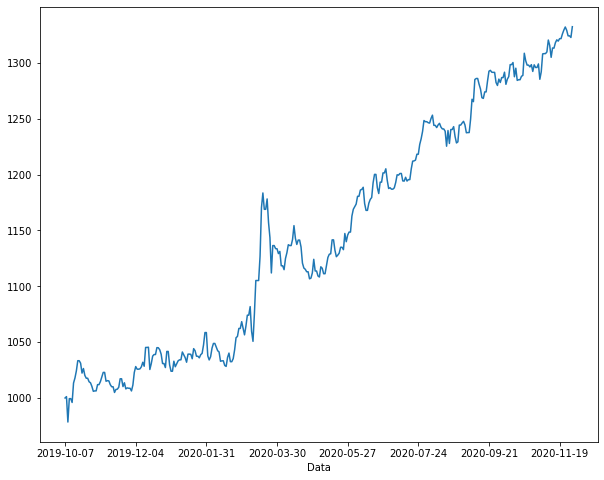

In [132]:
dfMACD['Saldo'].plot(figsize=(10,8))

In [133]:
#calculando o retorno
dfMACD['Retorno']=dfMACD['Saldo'].pct_change()
dfMACD['R. Acumulado'] = (dfMACD['Retorno']).cumprod()

In [134]:
dfMACD

,Saldo,Close,MACD,Linha de Sinal,yesterday price,change,retorno,invisted macd,Buy,Retorno,R. Acumulado
Data,,,,,,,,,,,
2019-10-07,1000.00,1.22162,-0.001379,0.000475,1.22881,0.994149,NaN,-1,NaN,NaN,NaN
2019-10-08,1001.22,1.22040,-0.002138,-0.000048,1.22162,0.999001,NaN,-1,NaN,0.001220,1.220000e-03
2019-10-09,978.48,1.24314,-0.000895,-0.000217,1.22040,1.018633,NaN,-1,NaN,-0.022712,-2.770900e-05
2019-10-10,999.42,1.26408,0.001760,0.000178,1.24314,1.016844,1.080075,1,1.26408,0.021401,-5.929874e-07
2019-10-11,999.42,1.26408,0.003820,0.000907,1.26408,1.000000,1.080075,1,NaN,0.000000,-0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
2020-11-25,1329.08,1.33566,0.008713,0.007582,1.33860,0.997804,1.263623,1,NaN,-0.002207,0.000000e+00
2020-11-26,1324.10,1.33068,0.008248,0.007715,1.33566,0.996272,1.258912,1,NaN,-0.003747,-0.000000e+00
2020-11-27,1324.10,1.33068,0.007789,0.007730,1.33068,1.000000,1.258912,1,NaN,0.000000,-0.000000e+00


# Calculando as métricas de desempenho

# Índice de Sharpe

In [135]:
#primeiro calcular o indice sharpe pegando a media do retorno diario e dividindo pelo desvio padrão
Sharpe_Ratio3 = (dfMACD['Retorno'].mean()*(255-0.01)) /(dfMACD['Retorno'].std()*np.sqrt(255))
print(Sharpe_Ratio3)

1.9282689384723708


# Retorno Anualizado

In [136]:
Retorno_anualizado3 = (1+dfMACD['Retorno'].sum())**0.5
print(Retorno_anualizado3)

1.1381109075871494


# Máximo Drawdown

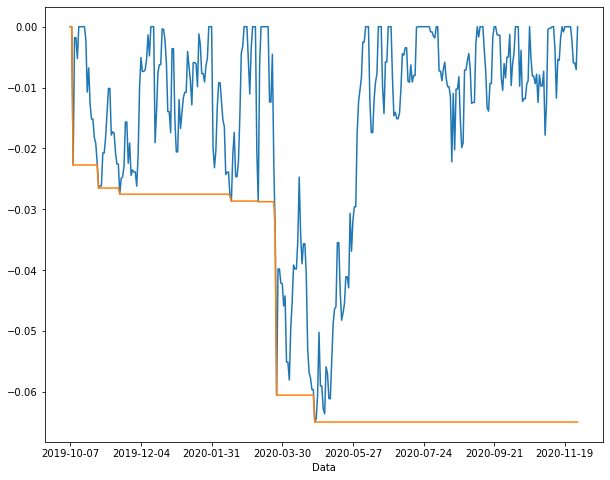

In [137]:
Roll_Max3 = dfMACD['Saldo'].cummax()
Daily_Drawdown3 = dfMACD['Saldo']/Roll_Max3 - 1.0
MDD3 = Daily_Drawdown3.cummin()
# Plotando o resultado
Daily_Drawdown3.plot(figsize =(10,8))
MDD3.plot(figsize=(10,8))

In [138]:
MDD3.min()

-0.06491816576396958

# Índice de Calmar

In [139]:
Calmar_Ratio3 = -(dfMACD['Retorno'].mean()*255)/MDD3.min()
print(Calmar_Ratio3)

3.2310055173649803


# Testando para SVM

# Primeiro utilizando o SVM sem o grid_search()

In [48]:
#fazendo os imports
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


In [49]:
amostra

,Open,High,Low,Close,Volume,body,pavio_sup,pavio_inf,SMA_50,SMA_20,...,lag_return_92,return_93,lag_return_93,return_94,lag_return_94,return_95,lag_return_95,return_96,lag_return_96,sobe_desce
Gmt time,,,,,,,,,,,,,,,,,,,,,
2018-12-31,1.27526,1.27526,1.27526,1.27526,0.0000,0.0,0.0,0.0,1.276439,1.263890,...,0.000000,-0.024016,-0.003022,-0.026965,0.004707,-0.022385,0.001128,-0.021282,0.000353,-1
2019-01-01,1.27459,1.27729,1.25808,1.26060,237090.4674,-139.9,27.0,25.2,1.275572,1.264123,...,0.006888,-0.035235,0.000000,-0.035235,-0.003022,-0.038150,0.004707,-0.033623,0.001128,1
2019-01-02,1.26060,1.26472,1.24250,1.26278,268812.2580,21.8,19.4,181.0,1.274637,1.264843,...,-0.000676,-0.040178,0.006888,-0.033567,0.000000,-0.033567,-0.003022,-0.036487,0.004707,1
2019-01-03,1.26268,1.27443,1.26157,1.27170,259746.4183,90.2,27.3,11.1,1.273827,1.265284,...,-0.000365,-0.032744,-0.000676,-0.033398,0.006888,-0.026740,0.000000,-0.026740,-0.003022,-1
2019-01-04,1.27170,1.27170,1.27170,1.27170,0.0000,0.0,0.0,0.0,1.273140,1.265615,...,0.008841,-0.032391,-0.000365,-0.032744,-0.000676,-0.033398,0.006888,-0.026740,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-25,1.33820,1.33975,1.33217,1.33566,130982.3413,-25.4,15.5,34.9,1.306775,1.322022,...,0.001532,0.023424,0.000000,0.023424,-0.006947,0.016314,0.002234,0.018585,0.003190,-1
2020-11-26,1.33560,1.33814,1.32875,1.33068,197292.2507,-49.2,25.4,19.3,1.307675,1.323292,...,-0.001821,0.018048,0.001532,0.019608,0.000000,0.019608,-0.006947,0.012525,0.002234,-1
2020-11-27,1.33068,1.33068,1.33068,1.33068,0.0000,0.0,0.0,0.0,1.308461,1.324899,...,-0.001111,0.019905,-0.001821,0.018048,0.001532,0.019608,0.000000,0.019608,-0.006947,1


In [50]:
window = 240
total=amostra.iloc[(window):] #restante do dataframe que ele vai ir andando pelo walk forward
len(total)

360

In [51]:
#lista para armazenar os valores preditos
predicoes=[]
#lista para armazenar os valores reais
valor_real=[]
#lista de pips
pontos = []
#lista para as datas para o index
dias=[]

In [52]:
clf = make_pipeline(StandardScaler(), SVC(C= 1, gamma= 'auto', kernel= 'rbf'))

for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    treino = amostra.iloc[t:(window)]
    Y_treino=treino['sobe_desce']
    X_treino = treino.drop(columns = ['sobe_desce'])
    a_teste = amostra.iloc[(window):(window+60)] #trocar o indice
    Y_teste = a_teste['sobe_desce']
    X_teste = a_teste.drop(columns = ['sobe_desce'])
    
    
    #faz a predição e coleta o valor
    clf.fit(X_treino,Y_treino)
    yrf_pred=clf.predict(X_teste)
    acuracia=accuracy_score(Y_teste, yrf_pred)
    pontos.extend(X_teste['body'])
    predicoes.extend(yrf_pred)
    dias.extend(X_teste.index)
   
    
  
    #coleta os valores reais da saída
    valor_real.extend(Y_teste)
    
    #desliza a janela em 60 que é o número do conjunto de teste
  
    window= window+60
    
    print(acuracia)

0.5166666666666667
0.6166666666666667
0.6
0.55
0.55
0.45


# Calculando os retornos

In [53]:
lucroSvm = pd.DataFrame(dias)
lucroSvm.columns=['Data']
lucroSvm.set_index('Data', inplace = True)
lucroSvm.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
lucroSvm.head()

,Saldo
Data,
2019-10-07,1000
2019-10-08,1000
2019-10-09,1000
2019-10-10,1000
2019-10-11,1000


In [54]:
saldo =1000

In [55]:

for i in np.arange(1,len(predicoes)):
    
    if predicoes[i] == valor_real[i]:
        saldo = saldo + abs(pontos[i]*0.1)
        lucroSvm.iloc[i] = saldo
         
    else:
        saldo = saldo - abs(pontos[i]*0.1)
        lucroSvm.iloc[i] = saldo 

In [56]:
lucroSvm

,Saldo
Data,
2019-10-07,1000.00
2019-10-08,998.76
2019-10-09,976.02
2019-10-10,997.37
2019-10-11,997.37
...,...
2020-11-25,1344.19
2020-11-26,1349.11
2020-11-27,1349.11


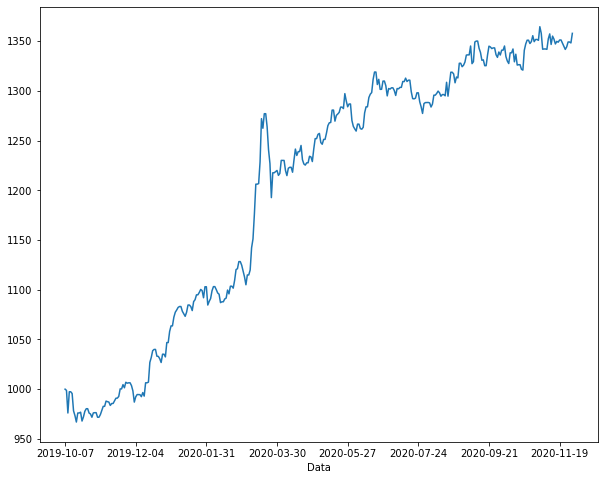

In [57]:
lucroSvm['Retorno']=lucroSvm['Saldo'].pct_change()
lucroSvm['R. Acumulado'] = (1+lucroSvm['Retorno']).cumprod()
lucroSvm['Retorno'].iloc[0] = 0
lucroSvm['R. Acumulado'].iloc[0]=0
lucroSvm['Saldo'].plot(figsize=(10,8))

In [125]:
lucroSvm.insert(loc=0, column='Ordem', value=predicoes, allow_duplicates=False)

In [126]:
lucroSvm

,Ordem,Saldo,Retorno,R. Acumulado
Data,,,,
2019-10-07,-1,1000.00,0.000000,0.00000
2019-10-08,-1,998.76,-0.001240,0.99876
2019-10-09,-1,976.02,-0.022768,0.97602
2019-10-10,-1,997.37,0.021875,0.99737
2019-10-11,-1,997.37,0.000000,0.99737
...,...,...,...,...
2020-11-25,-1,1344.19,0.001893,1.34419
2020-11-26,-1,1349.11,0.003660,1.34911
2020-11-27,-1,1349.11,0.000000,1.34911


# Métricas de desempenho


# Índice de Sharpe

In [127]:
#primeiro calcular o indice sharpe pegando a media do retorno diario e dividindo pelo desvio padrão
Sharpe_Ratio4 =( lucroSvm['Retorno'].mean()*(255-0.01)) /(lucroSvm['Retorno'].std()*np.sqrt(255))
print(Sharpe_Ratio4)

2.1576716969978116


# Retorno anualizado

In [128]:
Retorno_anualizado4 = (1+lucroSvm['Retorno'].sum())**0.5
print(Retorno_anualizado4)

1.1460485829650426


# Máximo Drawdown

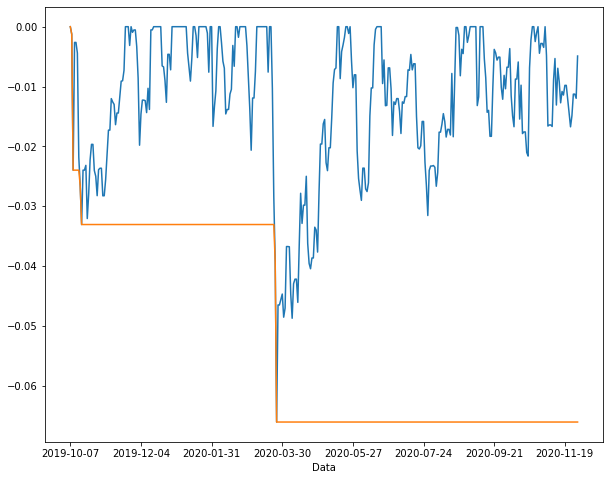

In [129]:
Roll_Max4 = lucroSvm['Saldo'].cummax()
Daily_Drawdown4 = lucroSvm['Saldo']/Roll_Max4 - 1.0
MDD4 = Daily_Drawdown4.cummin()
# Plotando o resultado
Daily_Drawdown4.plot(figsize =(10,8))
MDD4.plot(figsize=(10,8))

In [130]:
MDD4.min()

-0.06608560823192233

# Índice de Calmar

In [131]:
Calmar_Ratio4 = -lucroSvm['Retorno'].mean()*255/MDD4.min()
print(Calmar_Ratio4)

3.359446159641372


# Testando SVM com grid_search a cada passo do WFA

In [58]:
window = 240
total=amostra.iloc[(window):] #restante do dataframe que ele vai ir andando pelo walk forward
len(total)

360

In [59]:
C = [x for x in np.logspace(start = 2**-15, stop = 2**5)]
gamma =  [x for x in np.logspace(start = 2**-15, stop = 2**3)]

In [60]:
from sklearn.model_selection import GridSearchCV
# Cria a matriz de parametros
param_grid = {'C': C, 
              'gamma': gamma,
              'kernel': ['rbf']} 
# Instanciando o modelo de machine learning
clf = SVC()
# Instanciando o grid search
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [61]:
#lista para armazenar os valores preditos
predicoes=[]
#lista para armazenar os valores reais
valor_real=[]
#lista de pips
pontos = []
#lista para as datas para o index
dias=[]

for t in np.arange(0,len(total),60):
    
    #atualiza os dados de treino e de teste
    treino = amostra.iloc[t:(window)]
    Y_treino=treino['sobe_desce']
    X_treino = treino.drop(columns = ['sobe_desce'])
    a_teste = amostra.iloc[(window):(window+60)] #troca o indice
    Y_teste = a_teste['sobe_desce']
    X_teste = a_teste.drop(columns = ['sobe_desce'])
    
    #faz a predição e coleta o valor

    grid_search.fit(X_treino, Y_treino)
    clf_pred=grid_search.predict(X_teste)
    acuracia=accuracy_score(Y_teste, clf_pred)

    pontos.extend(X_teste['body'])
    predicoes.extend(clf_pred)
    dias.extend(X_teste.index)
   
    
  
    #coleta os valores reais da saída
    valor_real.extend(Y_teste)
    
    
    window= window+60
    print(acuracia)
    print(grid_search.best_params_)

Fitting 3 folds for each of 2500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 2720 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:   45.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.5166666666666667
{'C': 1.0000702717894114, 'gamma': 1.4564487290670938, 'kernel': 'rbf'}
Fitting 3 folds for each of 2500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 2720 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:   44.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.6166666666666667
{'C': 1.0000702717894114, 'gamma': 1.0000702717894114, 'kernel': 'rbf'}
Fitting 3 folds for each of 2500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 2720 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:   44.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.6
{'C': 1.0000702717894114, 'gamma': 3.0890473653058805, 'kernel': 'rbf'}
Fitting 3 folds for each of 2500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 2720 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:   44.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.5166666666666667
{'C': 1.0000702717894114, 'gamma': 1.0000702717894114, 'kernel': 'rbf'}
Fitting 3 folds for each of 2500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 2720 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:   46.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.5166666666666667
{'C': 1.0000702717894114, 'gamma': 20.237086317750475, 'kernel': 'rbf'}
Fitting 3 folds for each of 2500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 2720 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:   29.9s


0.4666666666666667
{'C': 1.0000702717894114, 'gamma': 20.237086317750475, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:   44.9s finished


# Calculando os retornos

In [62]:
lucroSvmg = pd.DataFrame(dias)
lucroSvmg.columns=['Data']
lucroSvmg.set_index('Data', inplace = True)
lucroSvmg.insert(loc=0, column='Saldo', value=1000, allow_duplicates=False)
lucroSvmg.head()

,Saldo
Data,
2019-10-07,1000
2019-10-08,1000
2019-10-09,1000
2019-10-10,1000
2019-10-11,1000


In [63]:
saldo =1000
for i in np.arange(1,len(predicoes)):
    
    if predicoes[i] == valor_real[i]:
        saldo = saldo + abs(pontos[i]*0.1)
        lucroSvmg.iloc[i] = saldo
         
    else:
        saldo = saldo - abs(pontos[i]*0.1)
        lucroSvmg.iloc[i] = saldo 

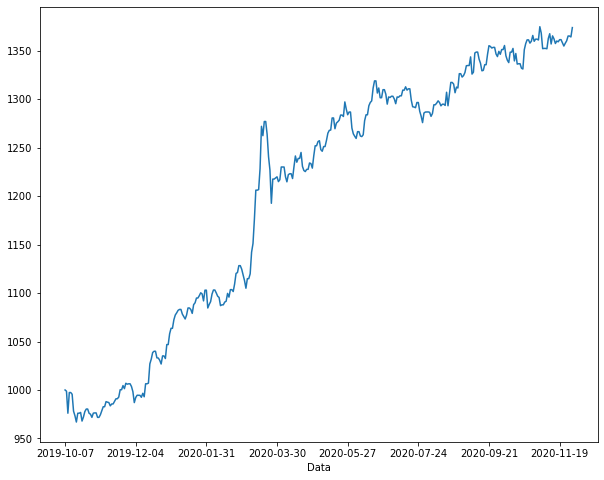

In [64]:
lucroSvmg['Retorno']=lucroSvmg['Saldo'].pct_change()
lucroSvmg['R. Acumulado'] = (1+lucroSvmg['Retorno']).cumprod()
lucroSvmg['Retorno'].iloc[0] = 0
lucroSvmg['R. Acumulado'].iloc[0]=0
lucroSvmg['Saldo'].plot(figsize=(10,8))

In [65]:
lucroSvmg.insert(loc=0, column='Ordem', value=predicoes, allow_duplicates=False)

In [66]:
lucroSvmg

,Ordem,Saldo,Retorno,R. Acumulado
Data,,,,
2019-10-07,-1,1000.00,0.000000,0.00000
2019-10-08,-1,998.76,-0.001240,0.99876
2019-10-09,-1,976.02,-0.022768,0.97602
2019-10-10,-1,997.37,0.021875,0.99737
2019-10-11,-1,997.37,0.000000,0.99737
...,...,...,...,...
2020-11-25,-1,1360.25,0.001871,1.36025
2020-11-26,-1,1365.17,0.003617,1.36517
2020-11-27,-1,1365.17,0.000000,1.36517


# Métricas de Desempenho

# Índice de Sharpe

In [67]:
#primeiro calcular o indice sharpe pegando a media do retorno diario e dividindo pelo desvio padrão
Sharpe_Ratio5 = ((255-0.01)*lucroSvmg['Retorno'].mean()) /(lucroSvmg['Retorno'].std()*np.sqrt(255))
print(Sharpe_Ratio5)

2.2415383653605736


# Retorno Anualizado

In [68]:
Retorno_anualizado5 = (1+lucroSvmg['Retorno'].sum())**0.5
print(Retorno_anualizado5)

1.1511630880838892


# Máximo Drawdown

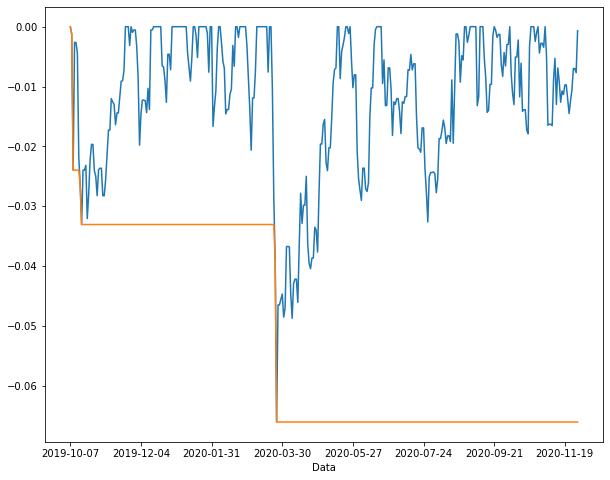

In [69]:
Roll_Max5 = lucroSvmg['Saldo'].cummax()
Daily_Drawdown5 = lucroSvmg['Saldo']/Roll_Max5 - 1.0
MDD5 = Daily_Drawdown5.cummin()
# Plotando o resultado
Daily_Drawdown5.plot(figsize =(10,8))
MDD5.plot(figsize=(10,8))

In [70]:
MDD5.min()

-0.06608560823192233

# Índice de Calmar

In [71]:
Calmar_Ratio5 = -(lucroSvmg['Retorno'].mean()*255)/MDD5.min()
print(Calmar_Ratio5)

3.48537796222094


# Gráfico retornos

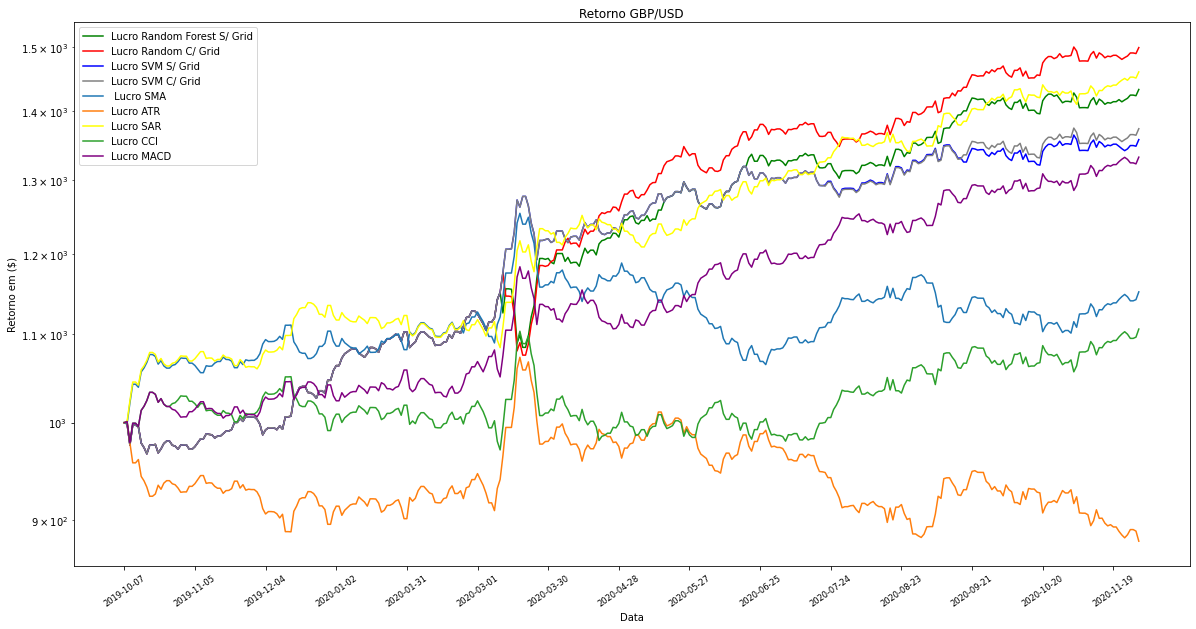

In [140]:
#Visualizando graficamente os retornos de cada estratégia
plt.figure(figsize= (20,10))
plt.plot(lucro.index, lucro['Saldo'], color = 'green', label = 'Lucro Random Forest S/ Grid', alpha=1)
plt.plot(lucroWFA.index, lucroWFA['Saldo'], color = 'red', label = 'Lucro Random C/ Grid', alpha=1)
plt.plot(lucroSvm.index, lucroSvm['Saldo'], color = 'blue', label = 'Lucro SVM S/ Grid', alpha=1)
plt.plot(lucroSvmg.index, lucroSvmg['Saldo'], color = 'gray', label = 'Lucro SVM C/ Grid', alpha=1)
plt.plot(dfSMA.index, dfSMA['Saldo'], label = ' Lucro SMA', alpha =1)
plt.plot(dfATR.index, dfATR['Saldo'], label = 'Lucro ATR', alpha = 1)
plt.plot(dfSAR.index, dfSAR['Saldo'], color='yellow', label = 'Lucro SAR', alpha =1)
plt.plot(dfCCI.index, dfCCI['Saldo'], label = 'Lucro CCI', alpha =1)
plt.plot(dfMACD['Saldo'], label='Lucro MACD',color='purple', alpha =1)
plt.title('Retorno GBP/USD')
plt.xticks(dfMACD.index[::25], size ='small', rotation=35 )
plt.yscale("log")
plt.xlabel('Data')
plt.ylabel('Retorno em ($)')
plt.legend( loc = 'upper left')
plt.show()

C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'upper Left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


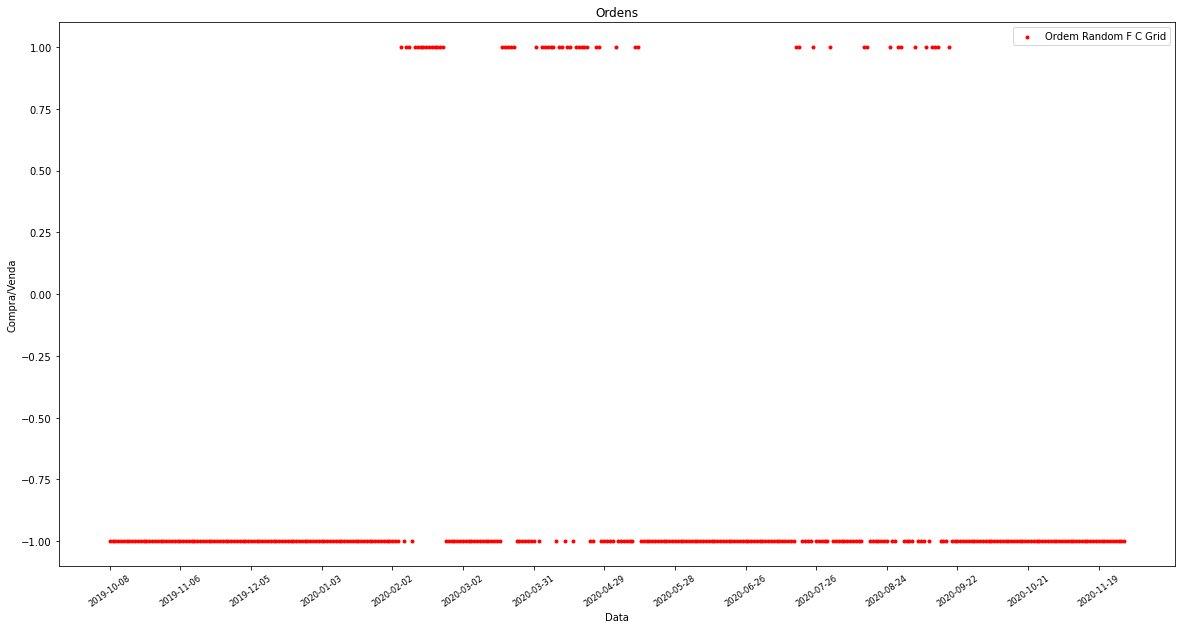

In [92]:
#Visualizando graficamente os sinais de compra e venda
plt.figure(figsize= (20,10))
# plt.scatter(lucro.index, lucro['Ordem'], color = 'green', label = 'Ordem Random F S Grid', marker = '.', alpha=1)
plt.scatter(lucroWFA.index, lucroWFA['Ordem'], color = 'red', label = 'Ordem Random F C Grid', marker = '.', alpha=1)
# plt.scatter(lucroSvm.index, lucroSvm['Ordem'], color = 'blue', label = 'Ordem SVM S Grid', marker = '.', alpha=1)
# plt.scatter(lucroSvmg.index, lucroSvmg['Ordem'], color = 'purple', label = 'Ordem SVM C Grid', marker = '+', alpha=1)
plt.title('Ordens')
plt.xticks(lucro.index[::25], size ='small', rotation=35 )
plt.xlabel('Data')
plt.ylabel('Compra/Venda')
plt.legend( loc = 'upper Left')
plt.show()

C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'upper Left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


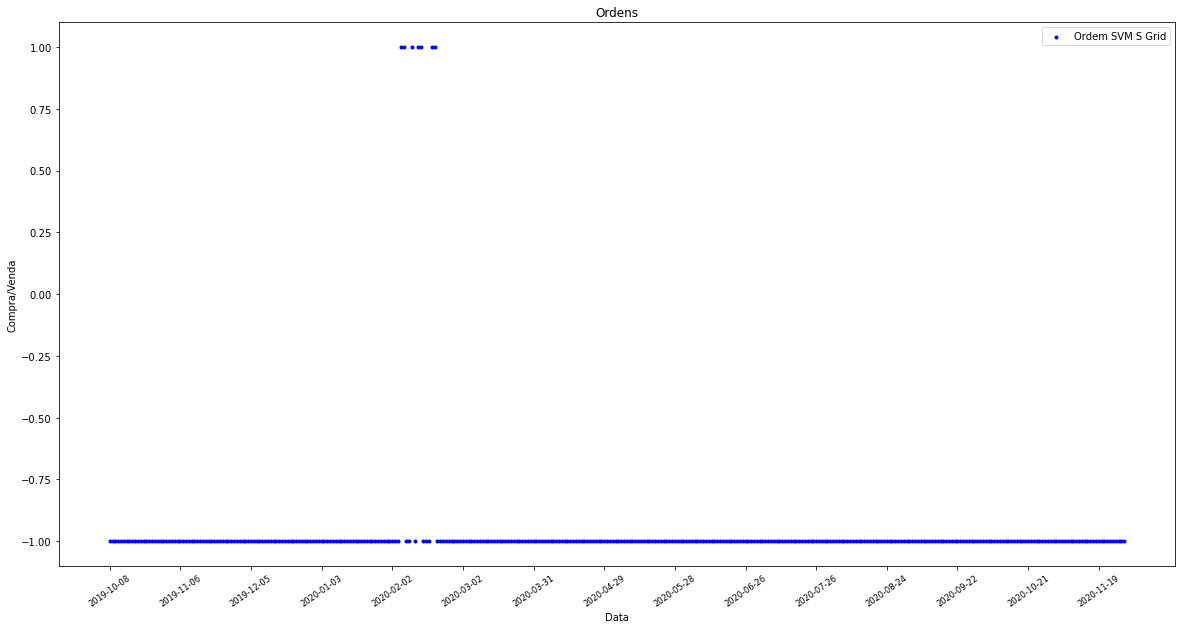

In [274]:
#Visualizando graficamente os sinais de compra e venda
plt.figure(figsize= (20,10))
# plt.scatter(lucro.index, lucro['Ordem'], color = 'green', label = 'Ordem Random F S Grid', marker = '.', alpha=1)
# plt.scatter(lucroWFA.index, lucroWFA['Ordem'], color = 'red', label = 'Ordem Random F C Grid', marker = '.', alpha=1)
plt.scatter(lucroSvm.index, lucroSvm['Ordem'], color = 'blue', label = 'Ordem SVM S Grid', marker = '.', alpha=1)
# plt.scatter(lucroSvmg.index, lucroSvmg['Ordem'], color = 'purple', label = 'Ordem SVM C Grid', marker = '+', alpha=1)
plt.title('Ordens')
plt.xticks(lucro.index[::25], size ='small', rotation=35 )
plt.xlabel('Data')
plt.ylabel('Compra/Venda')
plt.legend( loc = 'upper Left')
plt.show()

C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'upper Left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


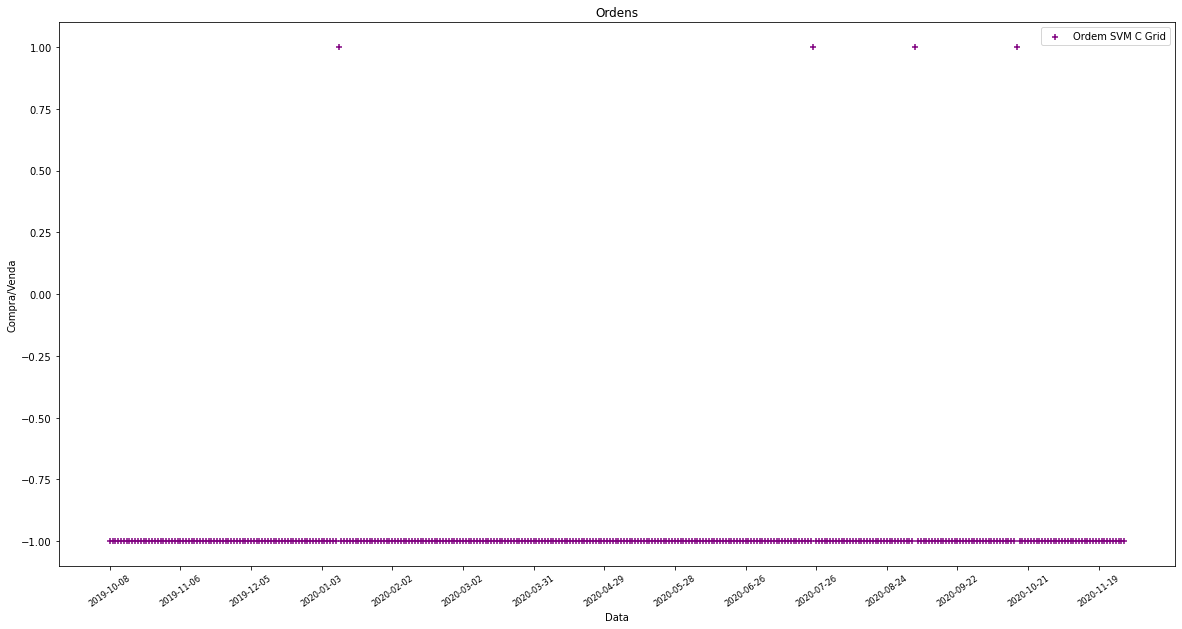

In [227]:
#Visualizando graficamente os sinais de compra e venda
plt.figure(figsize= (20,10))
# plt.scatter(lucro.index, lucro['Ordem'], color = 'green', label = 'Ordem Random F S Grid', marker = '.', alpha=1)
# plt.scatter(lucroWFA.index, lucroWFA['Ordem'], color = 'red', label = 'Ordem Random F C Grid', marker = '.', alpha=1)
# plt.scatter(lucroSvm.index, lucroSvm['Ordem'], color = 'blue', label = 'Ordem SVM S Grid', marker = '.', alpha=1)
plt.scatter(lucroSvmg.index, lucroSvmg['Ordem'], color = 'purple', label = 'Ordem SVM C Grid', marker = '.', alpha=1)
plt.title('Ordens')
plt.xticks(lucro.index[::25], size ='small', rotation=35 )
plt.xlabel('Data')
plt.ylabel('Compra/Venda')
plt.legend( loc = 'upper Left')
plt.show()

C:\Users\armando\anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'upper Left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


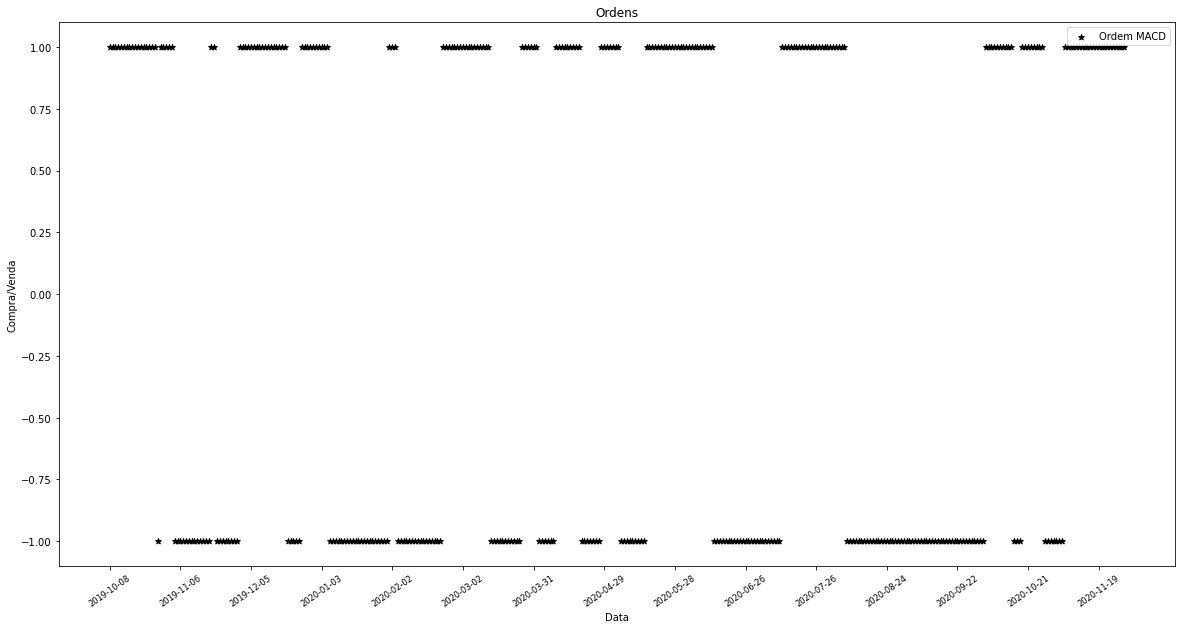

In [303]:
#Visualizando graficamente os sinais de compra e venda
plt.figure(figsize= (20,10))
# plt.scatter(lucro.index, lucro['Ordem'], color = 'green', label = 'Ordem Random F S Grid', marker = '.', alpha=1)
# plt.scatter(lucroWFA.index, lucroWFA['Ordem'], color = 'red', label = 'Ordem Random F C Grid', marker = '.', alpha=1)
# plt.scatter(lucroSvm.index, lucroSvm['Ordem'], color = 'blue', label = 'Ordem SVM S Grid', marker = '.', alpha=1)
plt.scatter(dfMACD.index, dfMACD['invisted macd'], color = 'black', label = 'Ordem MACD', marker = '*', alpha=1)
plt.title('Ordens')
plt.xticks(lucro.index[::25], size ='small', rotation=35 )
plt.xlabel('Data')
plt.ylabel('Compra/Venda')
plt.legend( loc = 'upper Left')
plt.show()

# Criando DataFrame com os índices

In [171]:
sharpe= [Sharpe_Ratio1,Sharpe_Ratio2,Sharpe_Ratio3,Sharpe_Ratio4,Sharpe_Ratio5, Sharpe_SMA, Sharpe_ATR, Sharpe_SAR, Sharpe_CCI]
calmar=[Calmar_Ratio1,Calmar_Ratio2,Calmar_Ratio3,Calmar_Ratio4,Calmar_Ratio5, Calmar_SMA, Calmar_ATR, Calmar_SAR, Calmar_CCI]
retornoa=[Retorno_anualizado1,Retorno_anualizado2,Retorno_anualizado3,Retorno_anualizado4,Retorno_anualizado5,Retorno_anualizadoSMA, Retorno_anualizadoATR, Retorno_anualizadoSAR,Retorno_anualizadoCCI]
estrategias=['Random Forest sem grid','Random Forest Com Grid','MACD','SVM sem grid','SVM com grid','SMA', 'ATR', 'SAR', 'CCI']
MDD=[MDD1.min(),MDD2.min(),MDD3.min(),MDD4.min(),MDD5.min(), MDDSMA.min(),MDDATR.min(),MDDSAR.min(),MDDCCI.min()]

In [172]:
dfRetorno=pd.DataFrame(estrategias)

In [173]:
dfRetorno.columns=['Estratégia']

In [174]:
dfRetorno.set_index('Estratégia', inplace=True)

In [175]:
dfRetorno.insert(loc=0, column='Sharpe', value=sharpe, allow_duplicates=False)
dfRetorno.insert(loc=1, column='Calmar', value=calmar, allow_duplicates=False)
dfRetorno.insert(loc=2, column='Retorno Anualizado', value=retornoa, allow_duplicates=False)
dfRetorno.insert(loc=3, column='Máximo DrawDown', value=MDD, allow_duplicates=False)

In [176]:
dfRetorno

,Sharpe,Calmar,Retorno Anualizado,Máximo DrawDown
Estratégia,,,,
Random Forest sem grid,2.496184,4.250808,1.169561,-0.061300
Random Forest Com Grid,2.841962,3.419152,1.188684,-0.085553
MACD,1.928269,3.231006,1.138111,-0.064918
SVM sem grid,2.157672,3.359446,1.146049,-0.066086
SVM com grid,2.241538,3.485378,1.151163,-0.066086
SMA,0.974930,0.702981,1.072232,-0.150821
ATR,-0.640506,-0.457398,0.940014,-0.180219
SAR,2.692609,5.782707,1.177474,-0.047468
CCI,0.657959,0.704106,1.054168,-0.111938
